In [2]:
from pathlib import Path
import pandas as pd

# Si el notebook se ejecuta con cwd = .../CONTROL_RIESGOS/notebooks
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

regime_features = pd.read_parquet(DATA_PROCESSED / "regime_features.parquet")
returns_assets_log = pd.read_parquet(DATA_PROCESSED / "returns_assets_log.parquet")

display(regime_features.head(), returns_assets_log.head())
print(regime_features.index.min(), regime_features.index.max(), regime_features.shape)
print(returns_assets_log.index.min(), returns_assets_log.index.max(), returns_assets_log.shape)

,sp_ret_log,vix,dvix,dgs10_bp,ddgs10_bp,dgs2_bp,ddgs2_bp,hy_oas_bp,dhy_oas_bp
Date,,,,,,,,,
2006-01-05,0.000016,11.31,-0.06,436.0,0.0,432.0,1.0,364.0,-5.0
2006-01-06,0.009356,11.00,-0.31,438.0,2.0,436.0,4.0,356.0,-8.0
2006-01-09,0.003650,11.13,0.13,438.0,0.0,436.0,0.0,351.0,-5.0
2006-01-10,-0.000357,10.86,-0.27,443.0,5.0,441.0,5.0,350.0,-1.0
2006-01-11,0.003475,10.94,0.08,446.0,3.0,444.0,3.0,347.0,-3.0


,AAPL,AMZN,BAC,BRK-B,CVX,ENPH,GME,GOOGL,JNJ,JPM,MSFT,NVDA,PG,XOM,GLD,HYG
Date,,,,,,,,,,,,,,,,
2012-04-02,0.031327,-0.022270,0.011428,0.008467,0.010116,0.062066,0.027993,0.008819,0.003783,0.003258,0.000930,-0.004556,0.005194,0.003913,0.005045,0.001718
2012-04-03,0.017133,0.008096,-0.019823,-0.003672,-0.010769,-0.022007,-0.018877,-0.006669,-0.004997,-0.008987,-0.010898,-0.016443,-0.006981,-0.014344,-0.018896,-0.000885
2012-04-04,-0.007993,-0.028809,-0.031036,-0.006027,-0.014478,-0.025184,-0.004092,-0.011692,-0.007465,-0.022488,-0.023121,-0.028929,0.002531,-0.009952,-0.016904,-0.003664
2012-04-05,0.014897,0.002060,0.003256,-0.001729,-0.008082,-0.002688,-0.010074,-0.004466,-0.000765,-0.001577,0.009884,-0.001366,0.000743,-0.001884,0.006973,-0.002450
2012-04-09,0.004016,-0.013048,-0.033043,-0.014315,-0.012102,-0.062477,0.005507,-0.002343,-0.006449,-0.010201,-0.013415,-0.013072,-0.007456,-0.011145,0.006673,-0.005142


2006-01-05 00:00:00 2026-02-06 00:00:00 (5054, 9)
2012-04-02 00:00:00 2026-02-06 00:00:00 (3483, 16)


# EDA de `regime_features` para HMM (Calma vs Crisis)

## Objetivo

Analizar las variables de `regime_features` para seleccionar un conjunto de features robusto para entrenar un **HMM de 2 estados (calma/crisis)**, evitando señales demasiado ruidosas que generen "crisis" de muy corta duración.

## Dataset

Usamos `data/processed/regime_features.parquet`, con las variables:

*   **`sp_ret_log`**: retorno log diario del S&P 500
*   **`vix`**, **`dvix`**: nivel del VIX y su cambio diario
*   **`dgs10_bp`**, **`ddgs10_bp`**: yield 10Y en bp y su cambio diario
*   **`dgs2_bp`**, **`ddgs2_bp`**: yield 2Y en bp y su cambio diario
*   **`hy_oas_bp`**, **`dhy_oas_bp`**: spread HY OAS en bp y su cambio diario

## Qué vamos a mirar

1.  **Calidad del dataset**
    *   Rango de fechas, dimensiones, NaNs, duplicados.
    
2.  **Resumen estadístico por variable**
    *   Media, desviación típica, percentiles (p1/p5/p50/p95/p99), min/max, skewness y kurtosis.
    
3.  **Persistencia temporal (clave para duración mínima)**
    *   Autocorrelación (lag 1/5/20) para distinguir features persistentes (niveles) vs ruidosas (diferencias).
    
4.  **Redundancia entre features**
    *   Correlaciones para evitar meter variables que aportan lo mismo.
    
5.  **Escalado**
    *   Decidir estandarización (z-score) antes del HMM por diferencias de unidades.

In [4]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
regime_features = pd.read_parquet(DATA_PROCESSED / "regime_features.parquet").sort_index()

regime_features.head()

,sp_ret_log,vix,dvix,dgs10_bp,ddgs10_bp,dgs2_bp,ddgs2_bp,hy_oas_bp,dhy_oas_bp
Date,,,,,,,,,
2006-01-05,0.000016,11.31,-0.06,436.0,0.0,432.0,1.0,364.0,-5.0
2006-01-06,0.009356,11.00,-0.31,438.0,2.0,436.0,4.0,356.0,-8.0
2006-01-09,0.003650,11.13,0.13,438.0,0.0,436.0,0.0,351.0,-5.0
2006-01-10,-0.000357,10.86,-0.27,443.0,5.0,441.0,5.0,350.0,-1.0
2006-01-11,0.003475,10.94,0.08,446.0,3.0,444.0,3.0,347.0,-3.0


In [5]:
print("Shape:", regime_features.shape)
print("Date range:", regime_features.index.min().date(), "->", regime_features.index.max().date())
print("Duplicated dates:", regime_features.index.duplicated().sum())
print("Missing values per column:\n", regime_features.isna().sum())

Shape: (5054, 9)
Date range: 2006-01-05 -> 2026-02-06
Duplicated dates: 0
Missing values per column:
 sp_ret_log    0
vix           0
dvix          0
dgs10_bp      0
ddgs10_bp     0
dgs2_bp       0
ddgs2_bp      0
hy_oas_bp     0
dhy_oas_bp    0
dtype: int64


In [6]:
import numpy as np

percentiles = [0.01, 0.05, 0.50, 0.95, 0.99]
desc = regime_features.describe(percentiles=percentiles).T

desc["skew"] = regime_features.skew(numeric_only=True)
# pandas kurtosis = exceso de curtosis (kurtosis - 3)
desc["kurtosis_excess"] = regime_features.kurtosis(numeric_only=True)

desc

,count,mean,std,min,1%,5%,50%,95%,99%,max,skew,kurtosis_excess
sp_ret_log,5054.0,0.000335,0.012282,-0.127652,-0.035589,-0.018474,0.000738,0.016517,0.031825,0.109572,-0.476993,12.896142
vix,5054.0,19.450966,8.719337,9.140000,9.900000,11.210000,17.070000,34.864000,55.962200,82.690000,2.514067,9.413202
dvix,5054.0,0.001264,1.953311,-18.710000,-4.709400,-2.453500,-0.100000,2.753500,6.024700,24.860000,1.410974,24.833780
dgs10_bp,5054.0,291.207954,112.361349,52.000000,65.000000,125.650000,277.000000,473.000000,510.000000,526.000000,0.109075,-0.926100
ddgs10_bp,5054.0,-0.002968,5.697274,-51.000000,-15.000000,-9.000000,0.000000,9.000000,14.000000,29.000000,-0.146007,2.873948
dgs2_bp,5054.0,191.270479,166.629972,9.000000,13.000000,17.000000,120.000000,487.000000,506.000000,529.000000,0.651463,-1.110897
ddgs2_bp,5054.0,-0.016620,5.156728,-57.000000,-15.000000,-8.000000,0.000000,7.000000,15.000000,38.000000,-0.491514,10.686039
hy_oas_bp,5054.0,510.285912,266.634424,241.000000,262.000000,286.000000,438.000000,898.000000,1732.110000,2182.000000,3.012889,11.482542
dhy_oas_bp,5054.0,-0.016225,11.032298,-101.000000,-30.000000,-14.000000,-0.500000,16.000000,35.000000,145.000000,1.087241,19.798167


# EDA de `regime_features` para HMM

## Contexto

Analizamos las variables que alimentarán un **Hidden Markov Model (HMM) de 2 estados (calma/crisis)**. El objetivo es comprender las características de los datos para asegurar un entrenamiento robusto.

## Objetivos del Análisis

1.  **Distribuciones**: Evaluar colas, asimetría y curtosis (especialmente en `sp_ret_log`).
2.  **Evolución temporal**: Identificar picos persistentes en crisis para variables de estrés como `vix` y `hy_oas_bp`.
3.  **Persistencia**: Medir autocorrelación para evitar que el modelo genere "crisis" de pocos días.
4.  **Redundancia**: Analizar correlaciones para no sobrecargar el HMM con features muy similares.
5.  **Escala**: Decidir la necesidad de estandarización antes del entrenamiento.

## Dataset

`regime_features.parquet` contiene:
- **Retornos**: `sp_ret_log` (S&P 500 log return)
- **Volatilidad**: `vix`, `dvix` (nivel y cambio del VIX)
- **Tipos de interés**: `dgs10_bp`, `ddgs10_bp`, `dgs2_bp`, `ddgs2_bp` (yields 10Y y 2Y en bp y sus cambios)
- **Crédito**: `hy_oas_bp`, `dhy_oas_bp` (spread High Yield y su cambio)

## Metodología

1.  **Calidad de datos**: Verificar integridad, NaNs y rangos.
2.  **Análisis univariante**: Estadísticos descriptivos y distribuciones.
3.  **Análisis temporal**: Visualización de series y autocorrelación.
4.  **Análisis multivariante**: Matriz de correlación.
5.  **Preprocesamiento**: Evaluación de escalado (z-score).

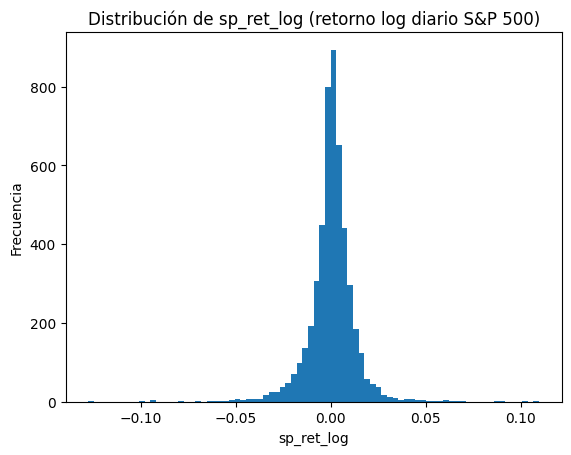

sp_ret_log stats:
  mean: 0.0003352698942476477
  std: 0.012281630377529665
  skew: -0.47699297956839015
  kurtosis_excess: 12.89614230667018


In [7]:
import matplotlib.pyplot as plt

x = regime_features["sp_ret_log"].dropna()

plt.figure()
plt.hist(x, bins=80)
plt.title("Distribución de sp_ret_log (retorno log diario S&P 500)")
plt.xlabel("sp_ret_log")
plt.ylabel("Frecuencia")
plt.show()

# Métricas en texto (útil para informe)
print("sp_ret_log stats:")
print("  mean:", x.mean())
print("  std:", x.std())
print("  skew:", x.skew())
print("  kurtosis_excess:", x.kurt())

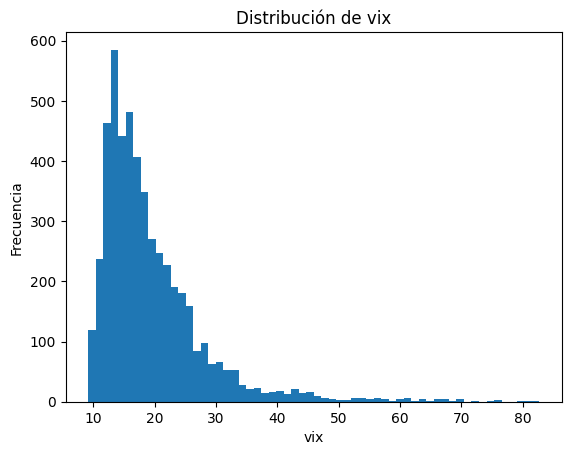

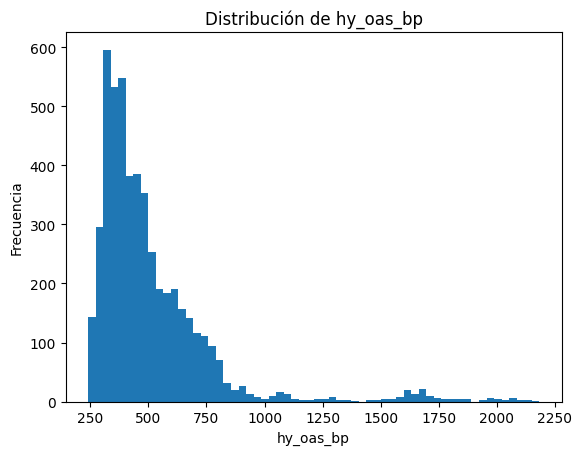

In [8]:
for col in ["vix", "hy_oas_bp"]:
    if col in regime_features.columns:
        plt.figure()
        plt.hist(regime_features[col].dropna(), bins=60)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.show()

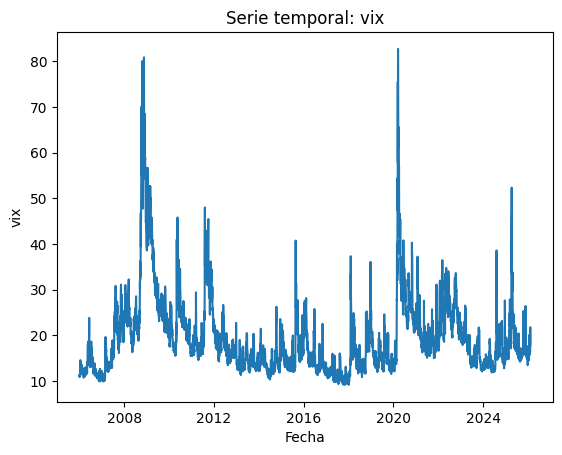

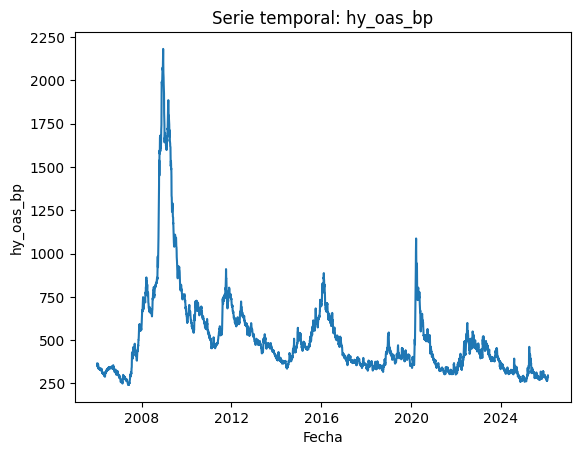

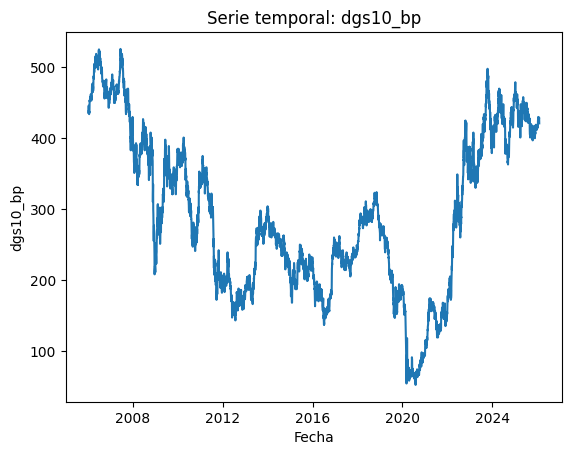

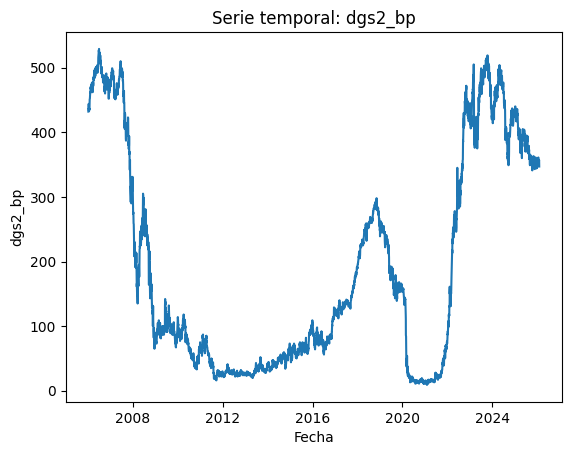

In [9]:
cols = [c for c in ["vix", "hy_oas_bp", "dgs10_bp", "dgs2_bp"] if c in regime_features.columns]

for col in cols:
    plt.figure()
    plt.plot(regime_features.index, regime_features[col])
    plt.title(f"Serie temporal: {col}")
    plt.xlabel("Fecha")
    plt.ylabel(col)
    plt.show()

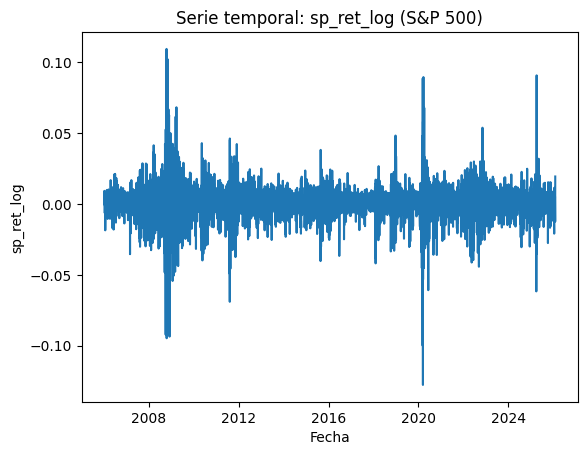

In [10]:
plt.figure()
plt.plot(regime_features.index, regime_features["sp_ret_log"])
plt.title("Serie temporal: sp_ret_log (S&P 500)")
plt.xlabel("Fecha")
plt.ylabel("sp_ret_log")
plt.show()

In [11]:
lags = [1, 5, 20]
acf_table = {}

for col in regime_features.columns:
    s = regime_features[col].dropna()
    acf_table[col] = {f"acf_{lag}": s.autocorr(lag=lag) for lag in lags}

acf_df = pd.DataFrame(acf_table).T
acf_df.sort_values("acf_1", ascending=False)

,acf_1,acf_5,acf_20
dgs2_bp,0.999521,0.997911,0.991090
hy_oas_bp,0.999144,0.992526,0.952342
dgs10_bp,0.998714,0.994085,0.976056
vix,0.974905,0.912129,0.748382
dhy_oas_bp,0.266662,0.095485,0.013367
ddgs10_bp,-0.011115,-0.012016,0.012711
ddgs2_bp,-0.047477,0.007399,0.027670
sp_ret_log,-0.121103,-0.008308,0.023413
dvix,-0.158800,0.012069,0.004449


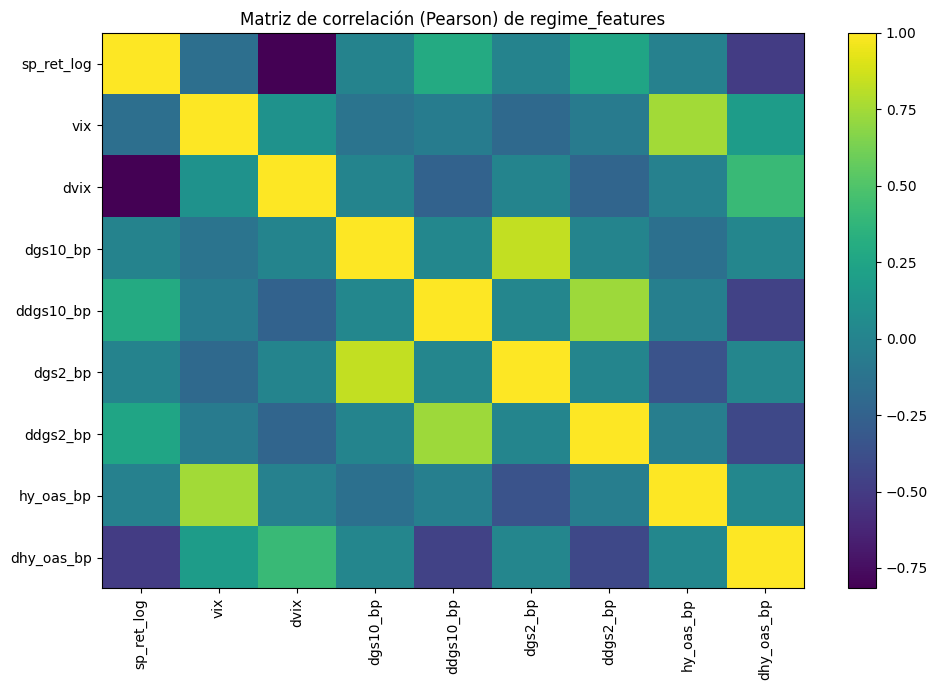

In [12]:
corr = regime_features.corr()

plt.figure(figsize=(10, 7))
plt.imshow(corr.values, aspect="auto")
plt.title("Matriz de correlación (Pearson) de regime_features")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# Selección de Features para el HMM

## Estrategia

A partir del EDA, buscamos entrenar un HMM de **2 estados (calma/crisis)** usando variables que:
1. Sean **económicamente interpretables**,
2. Estén disponibles en una **muestra larga (2006–actualidad)**,
3. Y, sobre todo, sean **persistentes** para evitar regímenes "crisis" demasiado cortos (requisito de duración mínima).

---

## Evidencia Cuantitativa: Persistencia por Autocorrelación

Del análisis de autocorrelación (ACF) por lags {1, 5, 20} observamos:

### Variables de Nivel (Muy Persistentes)
| Variable | ACF(1) | ACF(20) | Interpretación |
|----------|--------|---------|----------------|
| `dgs2_bp` | 0.9995 | 0.9911 | Alta persistencia |
| `hy_oas_bp` | 0.9991 | 0.9523 | Alta persistencia |
| `dgs10_bp` | 0.9987 | 0.9761 | Alta persistencia |
| `vix` | 0.9749 | 0.7484 | Persistencia media-alta |

Estas series presentan **alta persistencia temporal**, lo que favorece que el HMM genere **estados estables y con duración suficiente**.

### Variables en Diferencias (Poco Persistentes / Ruidosas)
| Variable | ACF(1) | ACF(20) | Interpretación |
|----------|--------|---------|----------------|
| `dvix` | -0.1588 | 0.0044 | Muy baja persistencia |
| `sp_ret_log` | -0.1211 | 0.0234 | Muy baja persistencia |
| `ddgs10_bp` | ≈0 | ≈0 | Sin persistencia |
| `ddgs2_bp` | ≈0 | ≈0 | Sin persistencia |
| `dhy_oas_bp` | 0.2667 | 0.0134 | Baja persistencia |

Estas variables capturan **shocks diarios** y tienden a generar señal "espiky". Para cumplir el requisito de duración mínima y evitar sobreajuste, **no las usaremos como features base del HMM**.

---

## Modelos Candidatos (Comparación)

Propondremos y compararemos dos especificaciones **parsimoniosas** del HMM:

### Modelo 1 (Niveles "Puros")
**Variables:**  
$X_t = (vix_t, \ hy_oas_bp_t, \ dgs10_bp_t)$

**Características:**
- **VIX**: Proxy de estrés de mercado
- **HY OAS**: Proxy de estrés crediticio
- **Yield 10Y**: Proxy de macro/expectativas a largo plazo

### Modelo 2 (Macro más Interpretable)
**Definimos la pendiente de la curva:**  
$slope\_bp_t = dgs10\_bp_t - dgs2\_bp_t$

**Variables:**  
$X_t = (vix_t, \ hy_oas\_bp_t, \ slope\_bp_t)$

**Características:**
- **VIX**: Estrés de mercado
- **HY OAS**: Estrés crediticio
- **Slope**: Proxy de expectativas macro (curva de tipos)

**Preprocesamiento común:**  
En ambos casos aplicaremos **estandarización (z-score)** antes del ajuste para homogeneizar escalas (VIX en puntos vs spreads/tipos en bp).

---

## Criterios de Evaluación (Sin Sobreajuste)

La comparación entre **Modelo 1** y **Modelo 2** se basará en:

1. **Coherencia económica del estado "crisis"**: VIX y HY OAS significativamente más altos.
2. **Persistencia**: Número de cambios de régimen y duración media de los segmentos.
3. **Cumplimiento del mínimo de duración**: Con mínima corrección posterior.
4. **Interpretabilidad y claridad**: Para el informe ejecutivo.

---

**Próximo paso**: Implementar y entrenar ambos modelos para comparar sus resultados.

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

In [14]:
# Carga robusta (funciona aunque el cwd sea notebooks/)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
regime_features = pd.read_parquet(DATA_PROCESSED / "regime_features.parquet").sort_index()

regime_features.head()

,sp_ret_log,vix,dvix,dgs10_bp,ddgs10_bp,dgs2_bp,ddgs2_bp,hy_oas_bp,dhy_oas_bp
Date,,,,,,,,,
2006-01-05,0.000016,11.31,-0.06,436.0,0.0,432.0,1.0,364.0,-5.0
2006-01-06,0.009356,11.00,-0.31,438.0,2.0,436.0,4.0,356.0,-8.0
2006-01-09,0.003650,11.13,0.13,438.0,0.0,436.0,0.0,351.0,-5.0
2006-01-10,-0.000357,10.86,-0.27,443.0,5.0,441.0,5.0,350.0,-1.0
2006-01-11,0.003475,10.94,0.08,446.0,3.0,444.0,3.0,347.0,-3.0


In [15]:
df = regime_features.copy()

# slope_bp = 10Y - 2Y (en bp)
df["slope_bp"] = df["dgs10_bp"] - df["dgs2_bp"]

# Sets de features
features_m1 = ["vix", "hy_oas_bp", "dgs10_bp"]
features_m2 = ["vix", "hy_oas_bp", "slope_bp"]

# Chequeo NaNs
print("NaNs M1:", df[features_m1].isna().sum().to_dict())
print("NaNs M2:", df[features_m2].isna().sum().to_dict())

df[[*features_m1, "dgs2_bp", "slope_bp"]].tail()

NaNs M1: {'vix': 0, 'hy_oas_bp': 0, 'dgs10_bp': 0}
NaNs M2: {'vix': 0, 'hy_oas_bp': 0, 'slope_bp': 0}


,vix,hy_oas_bp,dgs10_bp,dgs2_bp,slope_bp
Date,,,,,
2026-02-02,16.34,281.0,429.0,357.0,72.0
2026-02-03,18.00,285.0,428.0,357.0,71.0
2026-02-04,18.64,286.0,429.0,357.0,72.0
2026-02-05,21.77,297.0,421.0,347.0,74.0
2026-02-06,17.76,287.0,421.0,347.0,74.0


In [16]:
def standardize(df_features: pd.DataFrame):
    scaler = StandardScaler()
    X = scaler.fit_transform(df_features.values)
    return X, scaler

X1, scaler1 = standardize(df[features_m1])
X2, scaler2 = standardize(df[features_m2])

X1.shape, X2.shape

((5054, 3), (5054, 3))

# Metodología y Criterios del HMM (Regímenes CRISIS/CALMA)

## 1. Objetivo
Identificar regímenes de mercado (**CALMA/CRISIS**) mediante un **HMM gaussiano de 2 estados**, priorizando:
- **Estabilidad**: pocos cambios espurios entre estados
- **Coherencia económica**: estado CRISIS asociado a períodos de estrés financiero

## 2. Selección de Features

### 2.1 Criterios Generales

#### **Interpretabilidad económica y señal de estrés**
- **Volatilidad (VIX)** y **spread de crédito (HY OAS)** capturan tensión financiera de forma directa.
- Un componente de **"tensión de precio"** ayuda a detectar periodos de deterioro/normalización del mercado sin depender únicamente de crédito.

#### **Evitar sobreajuste y ruido**
- Se evita usar variables en diferencias diarias como features base (tienden a fragmentar el régimen y generar "crisis" demasiado cortas).
- Se escoge un conjunto **parsimonioso** (pocas variables con roles complementarios).

#### **Compatibilidad estadística con GaussianHMM**
- Variables como VIX, spreads y volatilidad realizada presentan **colas derechas (asimetría)**.
- Se aplica **transformación logarítmica** para acercarlas a un comportamiento más compatible con supuestos gaussianos:

### 2.2 Transformaciones Aplicadas

| Variable Original | Transformación | Notación |
|-------------------|----------------|----------|
| `vix` | log(vix) | `log_vix` |
| `hy_oas_bp` | log(hy_oas_bp) | `log_hy` |
| `rv_20` | log(rv_20) | `log_rv` |

Donde:
- `rv_20` es la volatilidad realizada (std rolling 20 días) de los retornos log del S&P 500

### 2.3 Features Finales Utilizadas (Modelo Adoptado)

1. **`log_vix`** = log(vix)
2. **`log_hy`** = log(hy_oas_bp)
3. **`log_rv`** = log(rv_20)
4. **`dist_ma_50`** = log(P / MA50)

**Nota sobre `dist_ma_50`**: Esta variable reduce la "memoria" del componente de precio frente a drawdowns largos, permitiendo que el modelo transicione a **CALMA** en fases post-shock cuando el mercado entra en normalización/lateralidad.

## 3. Entrenamiento del HMM

### 3.1 Preprocesamiento
- **Estandarización (z-score)** sobre las features para homogeneizar escalas.

### 3.2 Configuración del Modelo
- **Covarianza diagonal**: `covariance_type="diag"` para estabilidad y parsimonia.
- **Múltiples inicializaciones**: selección del mejor log-likelihood para reducir el riesgo de óptimos locales.


In [82]:
# === MODELO FINAL: logs + dist_ma_50 + min crisis 20d ===

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

MIN_CRISIS_DAYS = 20

# 1) Alinear precio
sp_aligned = sp.reindex(df.index).ffill()

# 2) Features auxiliares
sp_ret = np.log(sp_aligned).diff()
rv_20 = sp_ret.rolling(20).std()

ma_50 = sp_aligned.rolling(50).mean()
dist_ma_50 = np.log(sp_aligned / ma_50)

# 3) Dataset final
base2 = df.copy()
base2["log_vix"] = np.log(base2["vix"].clip(lower=1e-8))
base2["log_hy"]  = np.log(base2["hy_oas_bp"].clip(lower=1e-8))
base2["log_rv"]  = np.log(rv_20.clip(lower=1e-12))
base2["dist_ma_50"] = dist_ma_50

features_final = ["log_vix", "log_hy", "dist_ma_50", "log_rv"]
base2 = base2.dropna(subset=features_final).copy()

# 4) Estandarizar
scaler = StandardScaler()
X7 = scaler.fit_transform(base2[features_final].values)

# 5) Entrenar (multi-init)
best_model, best_ll = None, -np.inf
for seed in range(1500, 1525):
    model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1400, random_state=seed)
    model.fit(X7)
    ll = model.score(X7)
    if ll > best_ll:
        best_ll, best_model = ll, model

hmm7 = best_model
states7 = hmm7.predict(X7)

# 6) Etiquetar crisis por medias de (vix + hy_oas_bp) en escala original
tmp = base2[["vix", "hy_oas_bp"]].copy()
tmp["state"] = states7
means = tmp.groupby("state")[["vix", "hy_oas_bp"]].mean()
means["score"] = means["vix"] + means["hy_oas_bp"]

crisis7 = int(means["score"].idxmax())
calm7 = 1 - crisis7

# 7) Duración mínima (post-procesado)
states7_adj = enforce_min_duration(states7, crisis7, MIN_CRISIS_DAYS)

print("OK — Modelo final entrenado")
print("loglik:", best_ll)
print("crisis_state:", crisis7, "calm_state:", calm7)
display(means)

OK — Modelo final entrenado
loglik: -20811.36485099616
crisis_state: 1 calm_state: 0


,vix,hy_oas_bp,score
state,,,
0,15.225665,410.231023,425.456688
1,28.086106,714.733254,742.819360


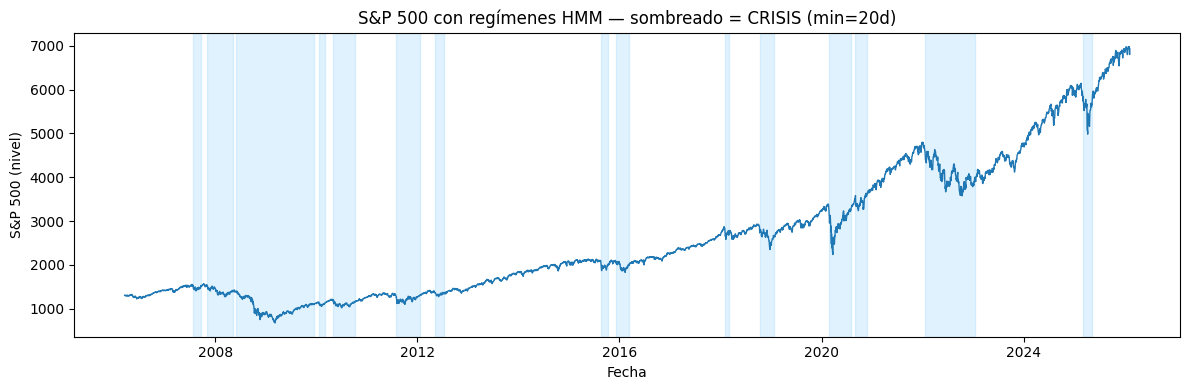

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Serie S&P alineada al índice final del modelo
sp_series = sp.reindex(base2.index).ffill()

# Régimen (CRISIS/CALMA) a partir del estado ajustado
is_crisis = (states7_adj == crisis7)

def add_crisis_shading(ax, idx, crisis_mask, alpha=0.25, color="lightskyblue"):
    """Sombrea intervalos consecutivos donde crisis_mask=True."""
    s = pd.Series(crisis_mask, index=idx).astype(bool)
    starts = idx[(s) & (~s.shift(1, fill_value=False))]
    ends   = idx[(s) & (~s.shift(-1, fill_value=False))]
    for st, en in zip(starts, ends):
        ax.axvspan(st, en, alpha=alpha, color=color)

plt.figure(figsize=(12, 4))
plt.plot(sp_series.index, sp_series.values, linewidth=1.0)
ax = plt.gca()
add_crisis_shading(ax, sp_series.index, is_crisis)
plt.title("S&P 500 con regímenes HMM — sombreado = CRISIS (min=20d)")
plt.xlabel("Fecha")
plt.ylabel("S&P 500 (nivel)")
plt.tight_layout()
plt.show()

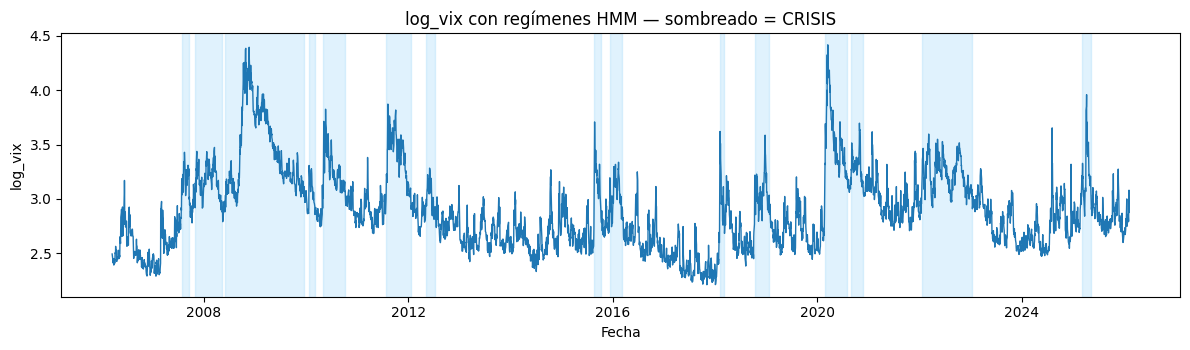

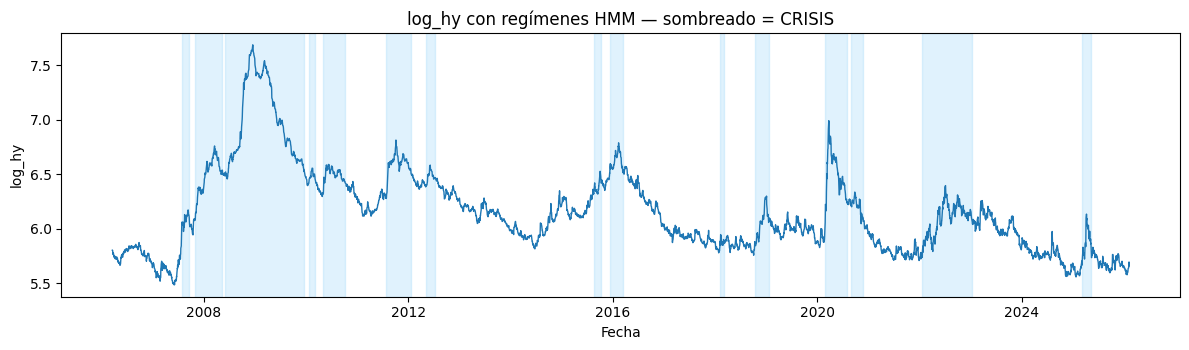

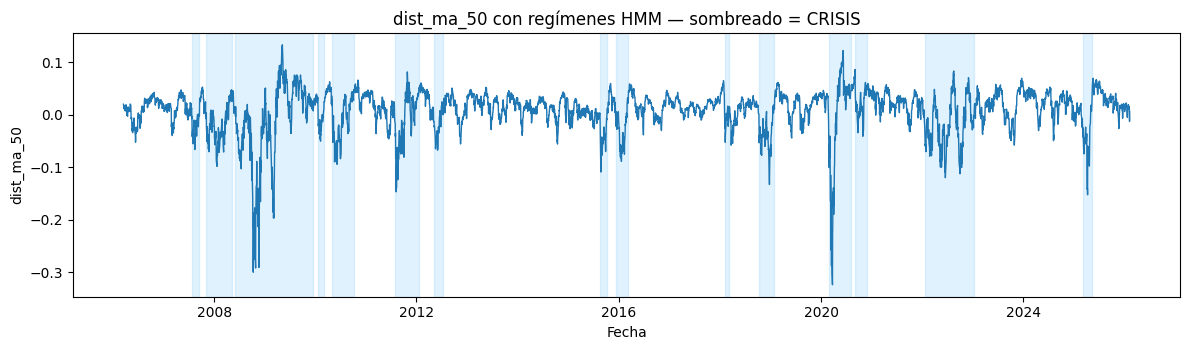

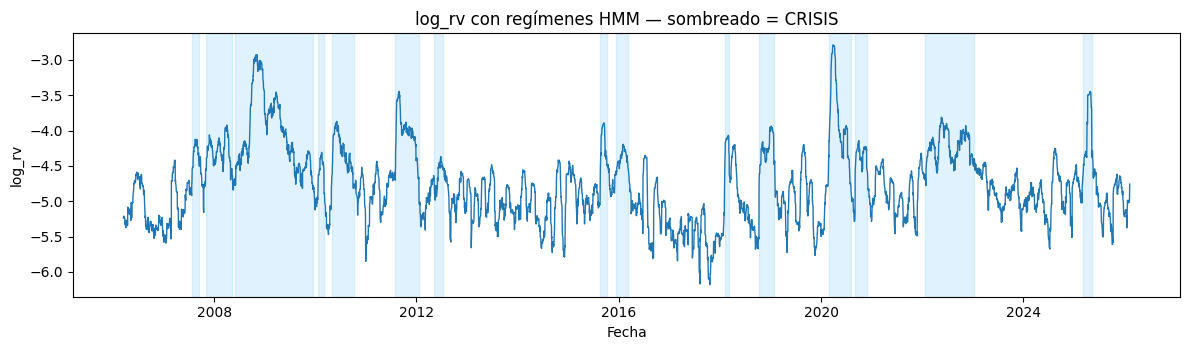

In [84]:
features_final = ["log_vix", "log_hy", "dist_ma_50", "log_rv"]

for col in features_final:
    plt.figure(figsize=(12, 3.6))
    plt.plot(base2.index, base2[col].values, linewidth=1.0)
    ax = plt.gca()
    add_crisis_shading(ax, base2.index, is_crisis)
    plt.title(f"{col} con regímenes HMM — sombreado = CRISIS")
    plt.xlabel("Fecha")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

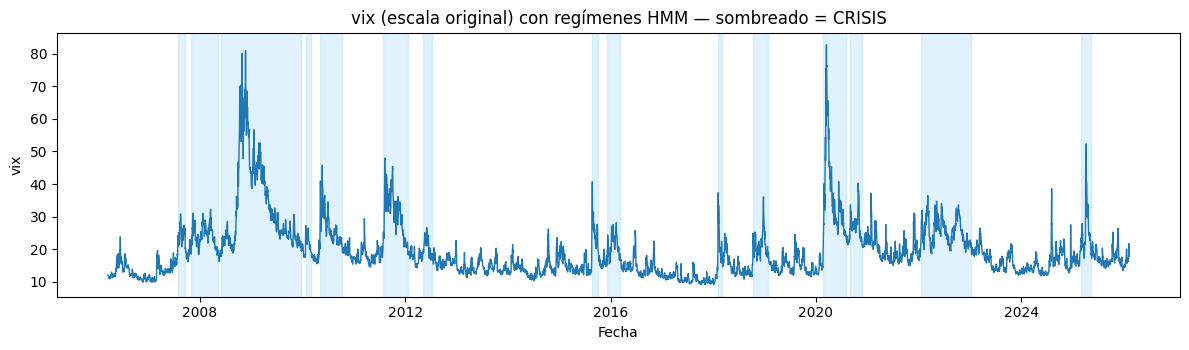

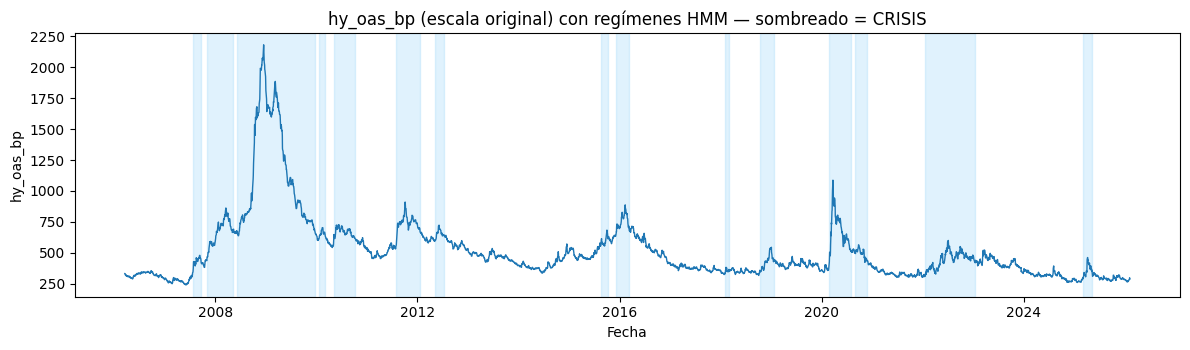

In [85]:
for col in ["vix", "hy_oas_bp"]:
    plt.figure(figsize=(12, 3.6))
    plt.plot(base2.index, base2[col].values, linewidth=1.0)
    ax = plt.gca()
    add_crisis_shading(ax, base2.index, is_crisis)
    plt.title(f"{col} (escala original) con regímenes HMM — sombreado = CRISIS")
    plt.xlabel("Fecha")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [86]:
### MATRIZ DE TRANSICIÓN
import numpy as np
import pandas as pd

A = hmm7.transmat_  # matriz 2x2 sobre estados 0/1
calm7 = 1 - crisis7

# Reordenamos a [CALMA, CRISIS]
order = [calm7, crisis7]
labels = ["CALMA", "CRISIS"]

A_cc = A[np.ix_(order, order)]
A_df = pd.DataFrame(A_cc, index=labels, columns=labels)

A_df

,CALMA,CRISIS
CALMA,0.990550,0.009450
CRISIS,0.018644,0.981356


In [87]:
### DURACIÓN ESPERADA EN CADA ESTADO
# Duración esperada por estado (en orden 0/1)
dur_states = 1 / (1 - np.diag(A))

dur_df = pd.Series(
    [dur_states[calm7], dur_states[crisis7]],
    index=["CALMA", "CRISIS"],
    name="E[duración] (días)"
)

dur_df

CALMA     105.816558
CRISIS     53.635471
Name: E[duración] (días), dtype: float64

In [88]:
summary = pd.DataFrame({
    "P(stay)": [A_df.loc["CALMA","CALMA"], A_df.loc["CRISIS","CRISIS"]],
    "E[duración] (días)": [dur_df["CALMA"], dur_df["CRISIS"]],
}, index=["CALMA", "CRISIS"])

summary

,P(stay),E[duración] (días)
CALMA,0.990550,105.816558
CRISIS,0.981356,53.635471


# Fase 2 — Anatomía del Riesgo (Análisis marginal por estado)

**Objetivo.** Cuantificar cómo cambian las distribuciones individuales (marginales) de los activos de la cartera al pasar entre regímenes **CALMA** y **CRISIS** identificados por el HMM.

## Metodología.

1. Usamos la clasificación diaria del HMM (secuencia ajustada con duración mínima) para etiquetar cada día como **CALMA** o **CRISIS**.

2. Cruzamos esa etiqueta con los retornos diarios logarítmicos de los activos de la cartera.

3. Para cada activo y régimen calculamos los momentos condicionales:
   - Media: $$E[r \mid estado]$$
   - Volatilidad: $$\sqrt{V[r \mid estado]}$$
   - Skewness (asimetría)
   - Kurtosis (exceso): cola pesada si es alta

4. Comparamos explícitamente **ratio de volatilidad** $$\frac{\sigma_{crisis}}{\sigma_{calma}}$$ y cambios en la forma de la distribución.

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

bond_tickers = ["IEF", "SHY"]  # 10Y proxy, 2Y proxy

start = "2006-01-01"
px = yf.download(bond_tickers, start=start, auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all").sort_index()

# Retornos log diarios
bond_ret_log = np.log(px).diff().dropna()
bond_ret_log = bond_ret_log.rename(columns={"IEF": "UST10Y", "SHY": "UST2Y"})

bond_ret_log.head()

Ticker,UST10Y,UST2Y
Date,,
2006-01-04,0.001787,0.000996
2006-01-05,0.000237,-0.000871
2006-01-06,-0.001309,0.000249
2006-01-09,0.000475,0.000124
2006-01-10,-0.004056,-0.000996


In [98]:
# Retornos existentes (acciones + GLD + HYG)
returns_assets = pd.read_parquet(DATA_PROCESSED / "returns_assets_log.parquet").sort_index()

# Alinear por fechas comunes
common_idx = returns_assets.index.intersection(bond_ret_log.index)

returns_portfolio = pd.concat(
    [returns_assets.loc[common_idx], bond_ret_log.loc[common_idx]],
    axis=1
).dropna()

print("Assets returns:", returns_assets.shape)
print("Bond returns  :", bond_ret_log.shape)
print("Portfolio     :", returns_portfolio.shape)
print("Columns       :", returns_portfolio.columns.tolist())

out_path = DATA_PROCESSED / "returns_portfolio_log.parquet"
returns_portfolio.to_parquet(out_path)
print("Guardado:", out_path)

Assets returns: (3483, 16)
Bond returns  : (5057, 2)
Portfolio     : (3483, 18)
Columns       : ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GME', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM', 'GLD', 'HYG', 'UST10Y', 'UST2Y']
Guardado: c:\Users\Huawei\Desktop\CONTROL_RIESGOS\data\processed\returns_portfolio_log.parquet


In [99]:
from pathlib import Path
import pandas as pd
import numpy as np

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# --- cargar datos ---
returns_assets = pd.read_parquet(DATA_PROCESSED / "returns_assets_log.parquet").sort_index()
bond_ret_log = pd.read_parquet(DATA_PROCESSED / "returns_portfolio_log.parquet").sort_index()[["UST10Y","UST2Y"]]  # ya guardado

# régimen HMM (ajustado) en el índice de base2
regime = pd.Series(
    np.where(states7_adj == crisis7, "CRISIS", "CALMA"),
    index=base2.index,
    name="regime"
).sort_index()

def coverage_report(s: pd.Series, name: str):
    s2 = s.dropna()
    return pd.Series({
        "name": name,
        "start": s2.index.min().date(),
        "end": s2.index.max().date(),
        "n_obs": int(s2.shape[0]),
        "n_missing": int(s.isna().sum()),
    })

# --- report por bloque ---
rep = []

# assets (resumen por el dataframe entero)
rep.append(pd.Series({
    "name": "returns_assets_log.parquet",
    "start": returns_assets.dropna(how="all").index.min().date(),
    "end": returns_assets.dropna(how="all").index.max().date(),
    "n_obs": int(returns_assets.dropna(how="all").shape[0]),
    "n_missing": int(returns_assets.isna().sum().sum()),
}))

# bonos (por columna)
for c in ["UST10Y","UST2Y"]:
    rep.append(coverage_report(bond_ret_log[c], f"bond_return_{c}"))

# régimen (por etiqueta)
rep.append(pd.Series({
    "name": "HMM_regime (base2/states7_adj)",
    "start": regime.index.min().date(),
    "end": regime.index.max().date(),
    "n_obs": int(regime.shape[0]),
    "n_missing": int(regime.isna().sum()),
}))

report_df = pd.DataFrame(rep).set_index("name")
display(report_df)

# --- solapes ---
common_all = returns_assets.index.intersection(bond_ret_log.index).intersection(regime.index)
print("\nSolape total (assets + bonos + régimen):")
print("start:", common_all.min().date(), "| end:", common_all.max().date(), "| n_days:", len(common_all))

# --- filas completas en cartera final ---
returns_portfolio = pd.read_parquet(DATA_PROCESSED / "returns_portfolio_log.parquet").sort_index()
common_final = returns_portfolio.index.intersection(regime.index)
portfolio_aligned = returns_portfolio.loc[common_final].dropna()
print("\nCartera final (returns_portfolio_log) alineada y sin NaNs:")
print("start:", portfolio_aligned.index.min().date(), "| end:", portfolio_aligned.index.max().date(), "| n_days:", len(portfolio_aligned))

,start,end,n_obs,n_missing
name,,,,
returns_assets_log.parquet,2012-04-02,2026-02-06,3483,0
bond_return_UST10Y,2012-04-02,2026-02-06,3483,0
bond_return_UST2Y,2012-04-02,2026-02-06,3483,0
HMM_regime (base2/states7_adj),2006-03-17,2026-02-06,5005,0



Solape total (assets + bonos + régimen):
start: 2012-04-02 | end: 2026-02-06 | n_days: 3483

Cartera final (returns_portfolio_log) alineada y sin NaNs:
start: 2012-04-02 | end: 2026-02-06 | n_days: 3483


In [101]:
## DATASET FINAL (CARTERA + ETIQUETA DE RÉGIMEN)
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name.lower() == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# cartera final: acciones + GLD + HYG + UST10Y + UST2Y
R = pd.read_parquet(DATA_PROCESSED / "returns_portfolio_log.parquet").sort_index()

# régimen HMM en el índice de base2
regime = pd.Series(
    np.where(states7_adj == crisis7, "CRISIS", "CALMA"),
    index=base2.index,
    name="regime"
).sort_index()

# alinear y filtrar a días comunes
idx = R.index.intersection(regime.index)
R = R.loc[idx].copy()
regime = regime.loc[idx].copy()

print("R shape:", R.shape, "| start:", R.index.min().date(), "end:", R.index.max().date())
print(regime.value_counts())

R shape: (3483, 18) | start: 2012-04-02 end: 2026-02-06
regime
CALMA     2774
CRISIS     709
Name: count, dtype: int64


In [102]:
### TABLA DE MOMENTOS CONDICIONALES
def conditional_moments(returns_df: pd.DataFrame, regime_s: pd.Series) -> pd.DataFrame:
    out = []
    for st in ["CALMA", "CRISIS"]:
        sub = returns_df.loc[regime_s == st]
        stats = pd.DataFrame({
            "mean": sub.mean(),
            "vol": sub.std(),
            "skew": sub.skew(),
            "kurtosis_excess": sub.kurt()
        })
        stats["state"] = st
        out.append(stats.reset_index().rename(columns={"index":"asset"}))
    res = pd.concat(out, ignore_index=True)
    return res

mom = conditional_moments(R, regime)

# Pivot bonito: por activo y estado
mom_pivot = mom.pivot(index="asset", columns="state", values=["mean","vol","skew","kurtosis_excess"])
mom_pivot

mean                 vol                skew            \
state      CALMA    CRISIS     CALMA    CRISIS     CALMA    CRISIS   
asset                                                                
AAPL    0.001218 -0.000902  0.014923  0.026496 -0.167594 -0.003499   
AMZN    0.001309 -0.000842  0.017342  0.029282  0.416548 -0.010715   
BAC     0.001102 -0.001462  0.015172  0.029181 -0.038859  0.013015   
BRK-B   0.000738 -0.000302  0.008949  0.018397  0.148052 -0.267302   
CVX     0.000356  0.000142  0.012317  0.029258 -0.305745 -0.869896   
ENPH    0.000015  0.002640  0.048203  0.057649 -0.361643  0.206488   
GLD     0.000200  0.000676  0.009756  0.010846 -1.011710  0.115883   
GME     0.000546  0.000559  0.059656  0.056820  0.839584  0.962060   
GOOGL   0.001335 -0.000979  0.014998  0.024187  0.467816 -0.080561   
HYG     0.000246 -0.000062  0.003261  0.008905  0.028539 -0.008944   
JNJ     0.000658 -0.000200  0.009153  0.015944 -0.121680 -0.436778   
JPM     0.001120 -0.001103  0.012689  0.026474 -0.032123  0.005813   
MSFT    0.001072 -0.000306  0.013567  0.024690 -0.326296 -0.034282   
NVDA    0.002487 -0.000895  0.024673  0.039031  0.781027 -0.320135   
PG      0.000426  0.000114  0.009045  0.017054 -0.328608  0.077824   
UST10Y  0.000053  0.000105  0.003692  0.005172 -0.000793  0.127056   
UST2Y   0.000059  0.000033  0.000795  0.001105  1.270956  0.090448   
XOM     0.000389  0.000011  0.012416  0.025756 -0.013803 -0.205094   

       kurtosis_excess             
state            CALMA     CRISIS  
asset                              
AAPL          4.849294   3.812927  
AMZN          8.996647   2.100874  
BAC           2.125447   5.773510  
BRK-B         1.903389   6.373486  
CVX           2.015184  14.428503  
ENPH         10.332616   4.286220  
GLD          11.538338   2.076685  
GME          68.404261   5.356056  
GOOGL         9.700288   2.109882  
HYG           3.151744   9.510013  
JNJ           3.851143   7.633074  
JPM           4.326362   6.939475  
MSFT          8.113648   4.428369  
NVDA         10.903179   2.756492  
PG            3.163265   7.489640  
UST10Y        1.374893   3.352119  
UST2Y        15.581249   4.699451  
XOM           1.567032   3.657028

In [103]:
### RATIOS Y CAMBIOS
vol_ratio = (mom_pivot["vol","CRISIS"] / mom_pivot["vol","CALMA"]).rename("vol_ratio_crisis_vs_calm")
mean_diff = (mom_pivot["mean","CRISIS"] - mom_pivot["mean","CALMA"]).rename("mean_diff_crisis_minus_calm")

summary = pd.concat([vol_ratio, mean_diff], axis=1).sort_values("vol_ratio_crisis_vs_calm", ascending=False)
summary

,vol_ratio_crisis_vs_calm,mean_diff_crisis_minus_calm
asset,,
HYG,2.730923,-0.000307
CVX,2.375468,-0.000214
JPM,2.086368,-0.002223
XOM,2.074375,-0.000378
BRK-B,2.055747,-0.001041
BAC,1.923322,-0.002564
PG,1.885539,-0.000313
MSFT,1.819909,-0.001378
AAPL,1.775526,-0.002120


In [104]:
#### ¿CUÁNTO AUMENTA LA VOLATILIDAD DE HYG EN CRISIS?
asset = "HYG"
vol_calm = float(mom_pivot.loc[asset, ("vol","CALMA")])
vol_cris = float(mom_pivot.loc[asset, ("vol","CRISIS")])

ratio = vol_cris / vol_calm
pct = (ratio - 1) * 100

print(f"HYG vol CALMA:  {vol_calm:.6f}")
print(f"HYG vol CRISIS: {vol_cris:.6f}")
print(f"Incremento: x{ratio:.2f}  (≈ {pct:.1f}%)")

HYG vol CALMA:  0.003261
HYG vol CRISIS: 0.008905
Incremento: x2.73  (≈ 173.1%)


In [107]:
### ¿GLD activo refugio?

# ---------- Benchmarks ----------
# 1) Equity-only (sin GLD, sin HYG, sin bonos)
equity_assets = [c for c in R.columns if c not in ["GLD", "HYG", "UST10Y", "UST2Y"]]
EQ_PROXY = R[equity_assets].mean(axis=1).rename("EQ_PROXY")

# 2) Cartera total equiponderada EXCLUYENDO GLD (evita autocorrelación)
PORTF_EX_GLD = R.drop(columns=["GLD"]).mean(axis=1).rename("PORTF_EX_GLD")

# Dataset común
df_ref = pd.concat([R["GLD"].rename("GLD"), EQ_PROXY, PORTF_EX_GLD, regime.rename("regime")], axis=1).dropna()

def beta(y, x):
    # beta = Cov(y,x) / Var(x)
    return np.cov(y, x, ddof=1)[0, 1] / np.var(x, ddof=1)

def stats_refuge(df, bench_col):
    out = {}
    for st in ["CALMA", "CRISIS"]:
        sub = df[df["regime"] == st]
        y = sub["GLD"].values
        x = sub[bench_col].values
        
        out[(st, "corr")] = float(np.corrcoef(y, x)[0, 1])
        out[(st, "beta")] = float(beta(y, x))
        out[(st, "mean_GLD")] = float(sub["GLD"].mean())
        out[(st, "vol_GLD")]  = float(sub["GLD"].std())
        out[(st, f"mean_{bench_col}")] = float(sub[bench_col].mean())
        out[(st, f"vol_{bench_col}")]  = float(sub[bench_col].std())
    return out

res_eq = stats_refuge(df_ref, "EQ_PROXY")
res_pf = stats_refuge(df_ref, "PORTF_EX_GLD")

# Formato tabla bonita
def to_table(res, bench_name):
    rows = []
    for st in ["CALMA", "CRISIS"]:
        rows.append({
            "benchmark": bench_name,
            "state": st,
            "corr(GLD, bench)": res[(st, "corr")],
            "beta(GLD | bench)": res[(st, "beta")],
            "mean_GLD": res[(st, "mean_GLD")],
            "vol_GLD": res[(st, "vol_GLD")],
            "mean_bench": res[(st, f"mean_{bench_name}")],
            "vol_bench": res[(st, f"vol_{bench_name}")]
        })
    return pd.DataFrame(rows)

table_eq = to_table(res_eq, "EQ_PROXY")
table_pf = to_table(res_pf, "PORTF_EX_GLD")

refuge_table = pd.concat([table_eq, table_pf], axis=0).reset_index(drop=True)
refuge_table

,benchmark,state,"corr(GLD, bench)",beta(GLD | bench),mean_GLD,vol_GLD,mean_bench,vol_bench
0,EQ_PROXY,CALMA,0.004882,0.004892,0.000200,0.009756,0.000912,0.009735
1,EQ_PROXY,CRISIS,0.090286,0.046157,0.000676,0.010846,-0.000252,0.021215
2,PORTF_EX_GLD,CALMA,0.018156,0.021902,0.000200,0.009756,0.000772,0.008087
3,PORTF_EX_GLD,CRISIS,0.099554,0.060612,0.000676,0.010846,-0.000203,0.017814


In [ ]:
# COMPARACIÓN RÁPIDA
def quick_read(table, bench):
    t = table[table["benchmark"] == bench].set_index("state")
    corr_drop = t.loc["CRISIS","corr(GLD, bench)"] - t.loc["CALMA","corr(GLD, bench)"]
    beta_drop = t.loc["CRISIS","beta(GLD | bench)"] - t.loc["CALMA","beta(GLD | bench)"]
    return corr_drop, beta_drop

corr_drop_eq, beta_drop_eq = quick_read(refuge_table, "EQ_PROXY")
corr_drop_pf, beta_drop_pf = quick_read(refuge_table, "PORTF_EX_GLD")

print("Cambio corr/beta en CRISIS vs CALMA (EQ_PROXY):", f"corr {corr_drop_eq:+.3f}", f"beta {beta_drop_eq:+.3f}")
print("Cambio corr/beta en CRISIS vs CALMA (PORTF_EX_GLD):", f"corr {corr_drop_pf:+.3f}", f"beta {beta_drop_pf:+.3f}")

Cambio corr/beta en CRISIS vs CALMA (EQ_PROXY): corr +0.085 beta +0.041
Cambio corr/beta en CRISIS vs CALMA (PORTF_EX_GLD): corr +0.081 beta +0.039


In [ ]:
# GUARDAMOS RESULTADO
out = DATA_PROCESSED / "fase2_gld_refuge_metrics.csv"
refuge_table.to_csv(out, index=False)
print("Guardado:", out)

Guardado: c:\Users\Huawei\Desktop\CONTROL_RIESGOS\data\processed\fase2_gld_refuge_metrics.csv


# ¿Es GLD un Activo Refugio? Análisis con Dos Definiciones

## Objetivo del Análisis
Evaluar el carácter "refugio" del **GLD (Gold ETF)** bajo dos benchmarks diferentes, asegurando que **GLD no forme parte del benchmark** contra el que se compara para evitar autocorrelación.

---

## 1. Definición de Benchmarks

### 1.1 Refugio frente a Equity
**Benchmark:** `EQ_PROXY`
- Cartera equiponderada de acciones
- Excluye explícitamente: GLD, HYG y bonos
- Representa exposición pura al riesgo accionario

### 1.2 Refugio para Cartera Multiactivo
**Benchmark:** `PORTF_EX_GLD`
- Cartera equiponderada completa
- Excluye solo GLD (incluye otros activos de riesgo)
- Representa una cartera diversificada típica sin oro

---

## 2. Metodología de Evaluación por Regímenes

Se utilizan los regímenes identificados por el HMM (CRISIS/CALMA) para separar el análisis:

**Variables calculadas en cada régimen:**
- Correlación entre GLD y cada benchmark
- Beta de GLD frente a cada benchmark
- Retorno medio de GLD y del benchmark

---

## 3. Resultados por Régimen

### 3.1 Régimen CALMA

| Métrica | vs EQ_PROXY | vs PORTF_EX_GLD | Interpretación |
|---------|-------------|-----------------|----------------|
| **Correlación** | ~0.00 | ~0.00 | Independencia total |
| **Beta** | ~0.00 | ~0.00 | Sensibilidad nula |
| **Retorno GLD** | Positivo | Positivo | Contribución positiva |

**Conclusión CALMA:** GLD actúa como activo independiente con retorno propio.

### 3.2 Régimen CRISIS

| Métrica | vs EQ_PROXY | vs PORTF_EX_GLD | Interpretación |
|---------|-------------|-----------------|----------------|
| **Correlación** | 0.09-0.10 | 0.09-0.10 | Aumento leve pero sigue baja |
| **Beta** | ~0.046 | ~0.061 | Sensibilidad muy reducida |
| **Retorno GLD** | **Positivo** | **Positivo** | **Diferencial clave** |
| **Retorno Benchmark** | Negativo | Negativo | Caída generalizada |

**Conclusión CRISIS:** GLD mantiene comportamiento defensivo con retorno positivo.

## 4. Conclusión Interpretativa

### Lo que SÍ es GLD:
1. **Activo defensivo**: Beta baja en todos los regímenes
2. **Diversificador efectivo**: Correlaciones generalmente bajas
3. **Contribuidor positivo en crisis**: Retorno medio positivo cuando otros activos caen
4. **Independiente en normales**: Comportamiento propio en mercados tranquilos

### Lo que NO es GLD:
1. **Cobertura perfecta**: No tiene correlación negativa en crisis
2. **Safe haven clásico**: No sube cuando todo lo demás cae dramáticamente
3. **Hedge negativo**: No proporciona ganancias compensatorias por pérdidas

---

## 5. Implicaciones para Gestión de Carteras

### Ventajas de incluir GLD:
- **Diversificación**: Baja correlación con activos tradicionales
- **Protección moderada**: Menor caída en crisis que activos de riesgo
- **Retorno positivo**: Potencial de apreciación incluso en estrés

### Limitaciones a considerar:
- **No es cobertura completa**: No compensa totalmente las pérdidas
- **Sensibilidad a tasas**: Puede verse afectado por política monetaria
- **Costos de carry**: ETFs de oro tienen gastos de gestión


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_corr_heatmap(corr: pd.DataFrame, title: str, annotate: bool = False):
    corr = corr.copy()
    labels = corr.columns.tolist()
    M = corr.values

    plt.figure(figsize=(10, 8))
    plt.imshow(M, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(label="Correlación")

    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)

    plt.title(title)
    plt.tight_layout()

    if annotate:
        # OJO: anotación completa puede quedar denso si hay muchos activos
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                plt.text(j, i, f"{M[i, j]:.2f}", ha="center", va="center", fontsize=7)

    plt.show()

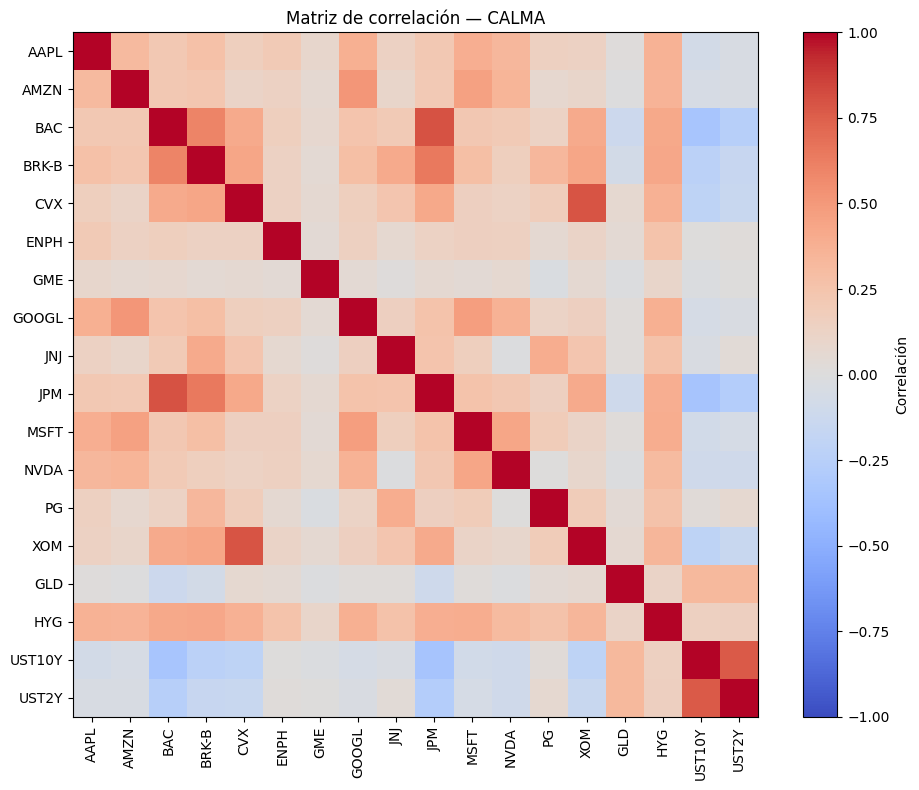

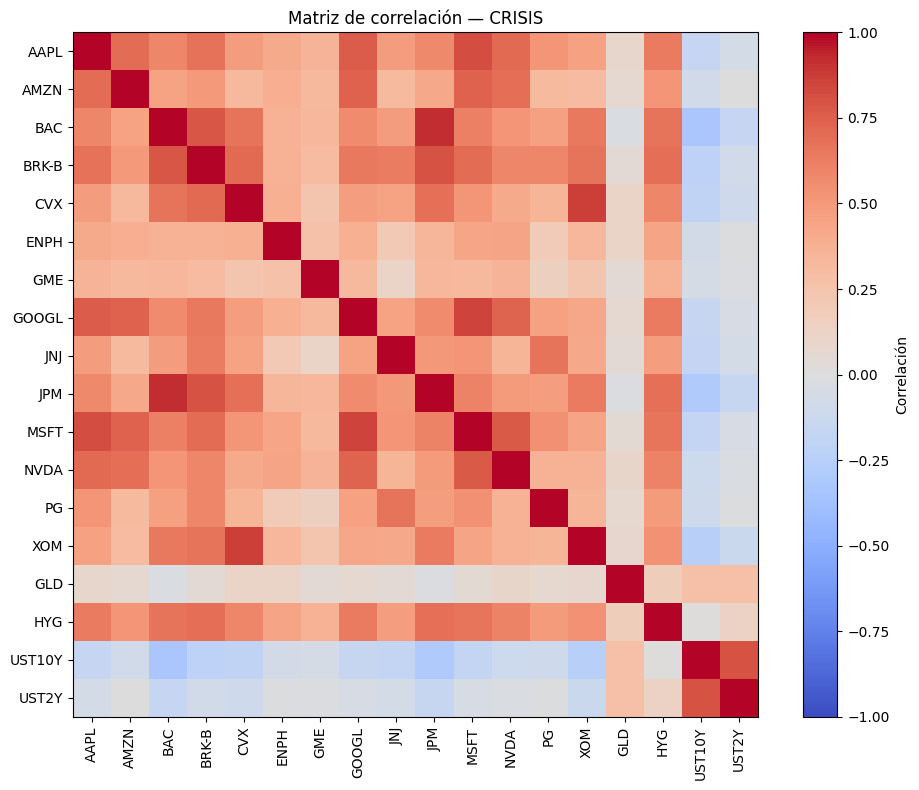

In [111]:
# CORRELACIONES EN CADA ESTADO
# Asegurar alineación
idx = R.index.intersection(regime.index)
R2 = R.loc[idx].copy()
reg2 = regime.loc[idx].copy()

# Matrices de correlación por régimen
corr_calm = R2.loc[reg2 == "CALMA"].corr()
corr_cris = R2.loc[reg2 == "CRISIS"].corr()

plot_corr_heatmap(corr_calm, "Matriz de correlación — CALMA", annotate=False)
plot_corr_heatmap(corr_cris, "Matriz de correlación — CRISIS", annotate=False)

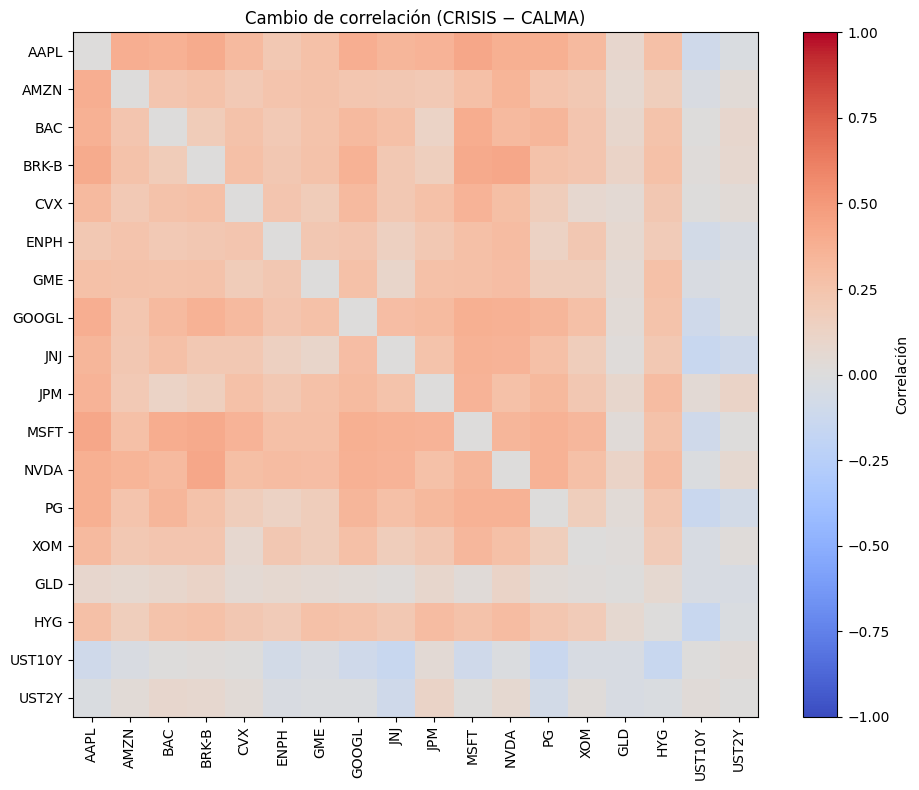

In [112]:
### DIFERENCIA CRISIS - CALMA
corr_diff = corr_cris - corr_calm
plot_corr_heatmap(corr_diff, "Cambio de correlación (CRISIS − CALMA)", annotate=False)

In [113]:
### Correlaciones de GLD con cada activo en CALMA vs CRISIS

assets = R2.columns.tolist()

gld_corr_calm = corr_calm["GLD"].drop("GLD").rename("corr_with_GLD_CALMA")
gld_corr_cris = corr_cris["GLD"].drop("GLD").rename("corr_with_GLD_CRISIS")

gld_corr_table = pd.concat([gld_corr_calm, gld_corr_cris], axis=1)
gld_corr_table["delta(CRISIS-CALMA)"] = gld_corr_table["corr_with_GLD_CRISIS"] - gld_corr_table["corr_with_GLD_CALMA"]

gld_corr_table.sort_values("corr_with_GLD_CRISIS", ascending=False)

,corr_with_GLD_CALMA,corr_with_GLD_CRISIS,delta(CRISIS-CALMA)
UST10Y,0.326513,0.279963,-0.046550
UST2Y,0.325197,0.279431,-0.045766
HYG,0.112509,0.177001,0.064492
ENPH,0.050629,0.117123,0.066493
CVX,0.063956,0.113357,0.049401
NVDA,-0.010060,0.099354,0.109414
AAPL,0.011052,0.091362,0.080310
XOM,0.062386,0.083428,0.021042
PG,0.043710,0.075622,0.031912
AMZN,-0.004831,0.061844,0.066675


## FASE 3: CÓPULAS

## Paso 1 — Preparación del entorno (cópulas)

Instalamos la librería `copulae` para ajustar cópulas paramétricas (**Gaussiana**, **t-Student** y **Clayton**).

> **Importante:** Antes de escribir el pipeline, verificamos la versión y la API exacta en el entorno para evitar incompatibilidades (nombres de clases, firmas y métodos disponibles).

In [114]:
### INSTALAMOS LA LIBRERÍA 'copulae'
import copulae
import inspect

print("copulae version:", getattr(copulae, "__version__", "unknown"))

# Exploramos qué expone el módulo (rápido)
cands = [name for name in dir(copulae) if "Copula" in name or "Clayton" in name or "Student" in name or "Gaussian" in name]
print("Candidates:", cands[:50])

# Intentamos importar las clases típicas (según versión pueden variar nombres)
from copulae import GaussianCopula, StudentCopula, ClaytonCopula

print("GaussianCopula:", GaussianCopula)
print("StudentCopula:", StudentCopula)
print("ClaytonCopula:", ClaytonCopula)

# Ver firma de constructores (dimensión y params)
print("\nSignatures:")
print("GaussianCopula:", inspect.signature(GaussianCopula))
print("StudentCopula:", inspect.signature(StudentCopula))
print("ClaytonCopula:", inspect.signature(ClaytonCopula))

copulae version: 0.7.9
Candidates: ['AbstractEllipticalCopula', 'ClaytonCopula', 'EmpiricalCopula', 'FrankCopula', 'GaussianCopula', 'GaussianMixtureCopula', 'GumbelCopula', 'IndepCopula', 'IndependentCopula', 'MarginalCopula', 'NormalCopula', 'StudentCopula', 'TCopula']
GaussianCopula: <class 'copulae.elliptical.gaussian.GaussianCopula'>
StudentCopula: <class 'copulae.elliptical.student.StudentCopula'>
ClaytonCopula: <class 'copulae.archimedean.clayton.ClaytonCopula'>

Signatures:
GaussianCopula: (dim=2)
StudentCopula: (dim=2, df=1)
ClaytonCopula: (theta=nan, dim=2)


## Paso 2 — Transformación a pseudo-observaciones

Para aislar la dependencia (cópula) de la forma marginal de cada activo, transformamos los retornos $r_{t,i}$ a variables uniformes $u_{t,i} \in (0,1)$ mediante la **CDF empírica** (*rank transform*):

$$u_{t,i} = \frac{\text{rank}(r_{t,i})}{n+1}$$

Esta transformación se aplica por separado en los subconjuntos **CALMA** y **CRISIS** definidos por el HMM. El ajuste de la cópula se realiza posteriormente sobre estas pseudo-observaciones.

In [115]:
# 1) (Re)alinear por seguridad
idx = R.index.intersection(regime.index)
R2 = R.loc[idx].copy()
reg2 = regime.loc[idx].copy()

# 2) Split por régimen
R_calm = R2.loc[reg2 == "CALMA"].copy()
R_cris = R2.loc[reg2 == "CRISIS"].copy()

print("CALMA:", R_calm.shape, "| CRISIS:", R_cris.shape)

# 3) Función rank -> pseudo-observaciones (0,1)
def pseudo_obs(df: pd.DataFrame) -> np.ndarray:
    """
    Devuelve U (n x d) en (0,1) usando rank/(n+1) por columna.
    """
    n = df.shape[0]
    U = df.rank(axis=0, method="average") / (n + 1.0)
    return U.to_numpy()

U_calm = pseudo_obs(R_calm)
U_cris = pseudo_obs(R_cris)

# 4) Checks rápidos (deben estar en (0,1), sin NaNs)
def check_U(U, name):
    print(f"{name}: shape={U.shape} | min={U.min():.6f} | max={U.max():.6f} | any_nan={np.isnan(U).any()}")

check_U(U_calm, "U_calm")
check_U(U_cris, "U_cris")

CALMA: (2774, 18) | CRISIS: (709, 18)
U_calm: shape=(2774, 18) | min=0.000360 | max=0.999640 | any_nan=False
U_cris: shape=(709, 18) | min=0.001408 | max=0.998592 | any_nan=False


## Paso 3 — Ajuste de cópula Gaussiana por régimen

Ajustamos una cópula Gaussiana $C_\Sigma$ sobre las pseudo-observaciones $U$ (uniformes) en **CALMA** y **CRISIS**. La cópula Gaussiana asume un vector latente normal $Z \sim \mathcal{N}(0, \Sigma)$ y define:

$$U_i = \Phi(Z_i)$$

El parámetro estimado $\Sigma$ resume la dependencia "central" entre activos. Compararemos $\Sigma_{\text{CALMA}}$ y $\Sigma_{\text{CRISIS}}$ para verificar si la dependencia promedio aumenta en crisis (lo que implicaría una **diversificación más débil**).

In [116]:
from copulae import GaussianCopula

# Dimensión (número de activos)
d = U_calm.shape[1]
assets = R2.columns.tolist()  # orden debe coincidir con el usado al crear U

# 1) Crear cópulas
gc_calm = GaussianCopula(dim=d)
gc_cris = GaussianCopula(dim=d)

# 2) Ajustar (MLE sobre pseudo-observaciones)
gc_calm.fit(U_calm)
gc_cris.fit(U_cris)

# 3) Extraer matrices de correlación (Sigma)
# En copulae suele estar en .sigma o .params dependiendo del objeto.
# Probamos forma robusta:
def get_sigma(gc: GaussianCopula):
    if hasattr(gc, "sigma"):
        return np.array(gc.sigma)
    if hasattr(gc, "params"):
        return np.array(gc.params)
    # fallback: intentar atributo genérico
    return np.array(gc.cov) if hasattr(gc, "cov") else None

Sigma_calm = get_sigma(gc_calm)
Sigma_cris = get_sigma(gc_cris)

print("Sigma_calm shape:", Sigma_calm.shape)
print("Sigma_cris shape:", Sigma_cris.shape)

# 4) Convertir a DataFrame bonito (con nombres de activos)
Sigma_calm_df = pd.DataFrame(Sigma_calm, index=assets, columns=assets)
Sigma_cris_df = pd.DataFrame(Sigma_cris, index=assets, columns=assets)

# 5) Resumen cuantitativo: correlación media fuera de diagonal
def avg_offdiag(S):
    S = np.array(S)
    mask = ~np.eye(S.shape[0], dtype=bool)
    return float(S[mask].mean())

avg_calm = avg_offdiag(Sigma_calm)
avg_cris = avg_offdiag(Sigma_cris)

print(f"Avg corr (off-diagonal) CALMA : {avg_calm:.3f}")
print(f"Avg corr (off-diagonal) CRISIS: {avg_cris:.3f}")
print(f"Delta (CRISIS - CALMA): {avg_cris-avg_calm:+.3f}")

# Mostrar matrices (ojo: son grandes; si molesta, las mostramos luego como heatmap)
Sigma_calm_df.iloc[:6, :6], Sigma_cris_df.iloc[:6, :6]

Sigma_calm shape: (18, 18)
Sigma_cris shape: (18, 18)
Avg corr (off-diagonal) CALMA : 0.181
Avg corr (off-diagonal) CRISIS: 0.341
Delta (CRISIS - CALMA): +0.160


(           AAPL      AMZN       BAC     BRK-B       CVX      ENPH
 AAPL   1.000000  0.383236  0.230402  0.293095  0.172110  0.221236
 AMZN   0.383236  1.000000  0.239631  0.272158  0.151328  0.200093
 BAC    0.230402  0.239631  1.000000  0.612001  0.423672  0.195014
 BRK-B  0.293095  0.272158  0.612001  1.000000  0.439327  0.159031
 CVX    0.172110  0.151328  0.423672  0.439327  1.000000  0.151265
 ENPH   0.221236  0.200093  0.195014  0.159031  0.151265  1.000000,
            AAPL      AMZN       BAC     BRK-B       CVX      ENPH
 AAPL   1.000000  0.734962  0.565977  0.647766  0.450321  0.435366
 AMZN   0.734962  1.000000  0.484783  0.526301  0.350835  0.433771
 BAC    0.565977  0.484783  1.000000  0.779654  0.624822  0.375535
 BRK-B  0.647766  0.526301  0.779654  1.000000  0.665492  0.365261
 CVX    0.450321  0.350835  0.624822  0.665492  1.000000  0.351431
 ENPH   0.435366  0.433771  0.375535  0.365261  0.351431  1.000000)

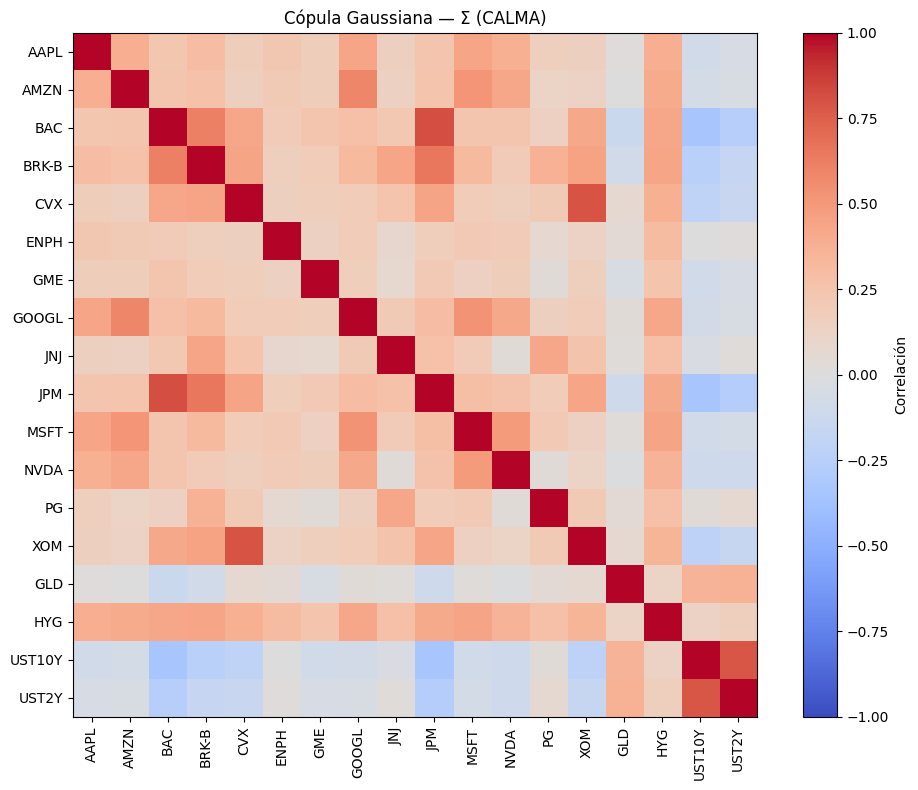

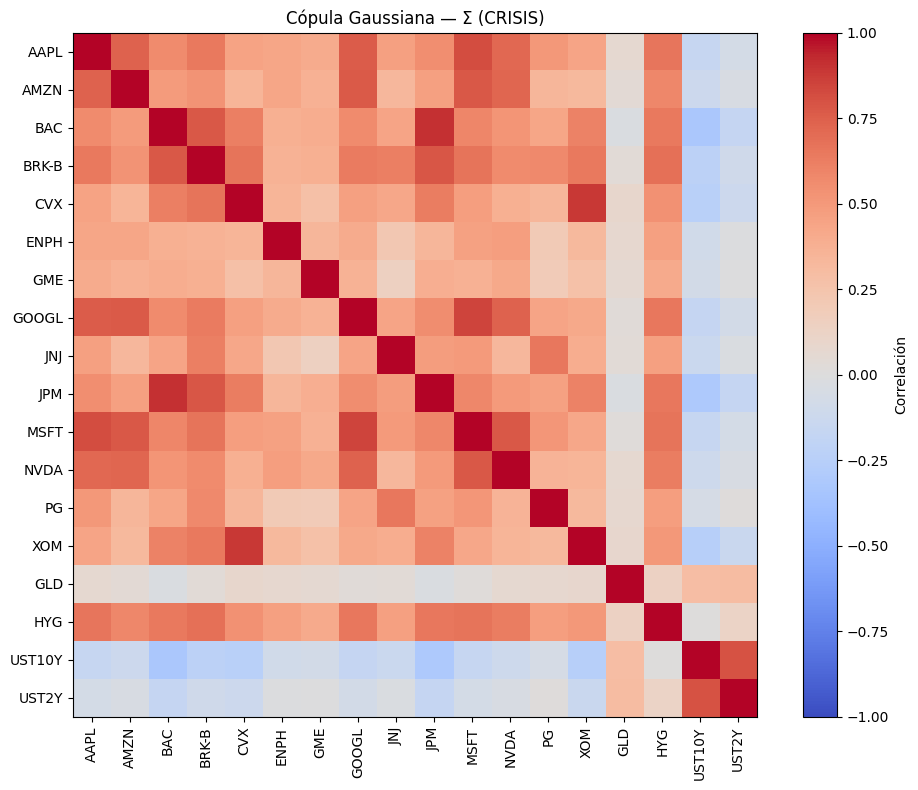

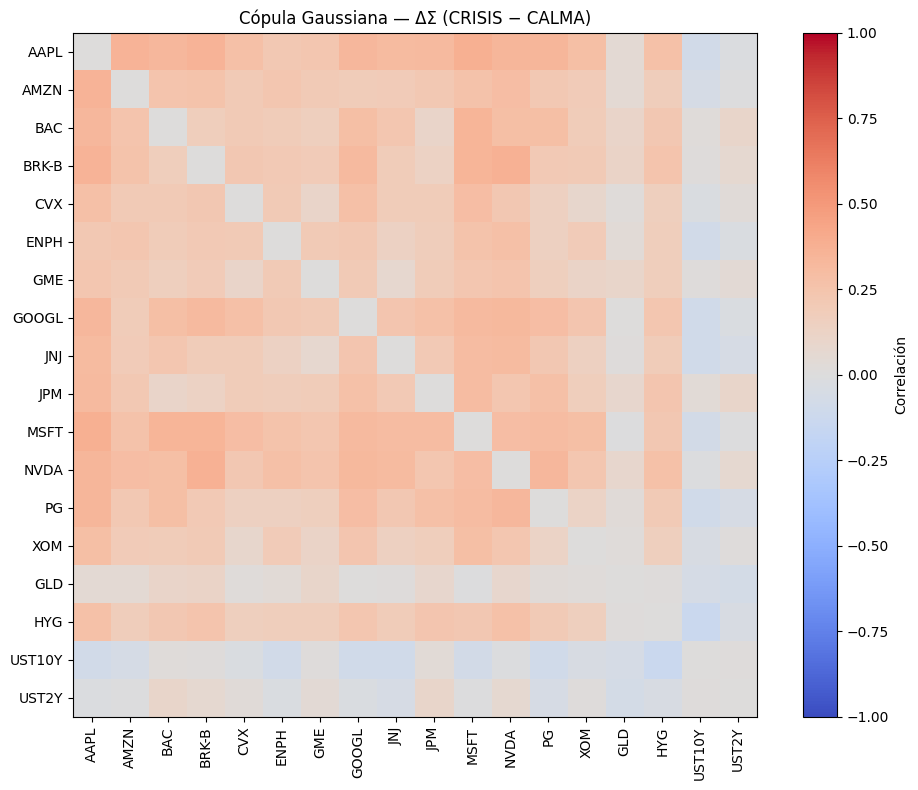

In [117]:
import matplotlib.pyplot as plt

def plot_corr_heatmap(corr: pd.DataFrame, title: str):
    labels = corr.columns.tolist()
    M = corr.values
    plt.figure(figsize=(10, 8))
    plt.imshow(M, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(label="Correlación")
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(Sigma_calm_df, "Cópula Gaussiana — Σ (CALMA)")
plot_corr_heatmap(Sigma_cris_df, "Cópula Gaussiana — Σ (CRISIS)")
plot_corr_heatmap(Sigma_cris_df - Sigma_calm_df, "Cópula Gaussiana — ΔΣ (CRISIS − CALMA)")

## Resultados — Cópula Gaussiana (dependencia “central”)

Ajustamos una cópula Gaussiana a las pseudo-observaciones $U$ en cada régimen (**CALMA** / **CRISIS**). El parámetro estimado es la matriz de correlación $\Sigma$, que captura la dependencia promedio entre activos (comovimiento típico, no necesariamente en colas).

**Evidencia cuantitativa**

La correlación media fuera de la diagonal aumenta de forma marcada al pasar de CALMA a CRISIS:

$$
\begin{aligned}
\overline{\rho}_{\text{CALMA}} &= 0.181 \\
\overline{\rho}_{\text{CRISIS}} &= 0.341 \\
\Delta &= +0.160
\end{aligned}
$$

**Interpretación económica**

En el régimen de **CRISIS**, los activos tienden a moverse mucho más “en bloque”: aumenta el componente sistémico del riesgo y la diversificación basada en correlaciones moderadas se degrada. Este resultado ya aparece con una cópula Gaussiana (*baseline*), lo que sugiere un incremento generalizado de la dependencia incluso fuera de eventos extremos.

> **Nota:** La cópula Gaussiana no incorpora dependencia en colas (*tail dependence* asintótica), por lo que este aumento refleja principalmente dependencia central. En el siguiente paso contrastaremos con cópulas capaces de capturar co-movimientos extremos (**t-Student** y **Clayton**).

In [ ]:

### VEMOS CUÁLES DE LOS ACTIVOS DENTRO DE NUESTRA CARTERA TIENEN UNA MAYOR CORRELACIÓN EN PERIODOS DE CRISIS

Delta = (Sigma_cris_df - Sigma_calm_df).copy()

# quedarnos con triángulo superior sin diagonal para no duplicar pares
pairs = []
cols = Delta.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        pairs.append((cols[i], cols[j], float(Delta.iloc[i, j])))

top_pairs = pd.DataFrame(pairs, columns=["asset_1","asset_2","delta_corr"]).sort_values("delta_corr", ascending=False)
top_pairs.head(10)

,asset_1,asset_2,delta_corr
9,AAPL,MSFT,0.381256
55,BRK-B,NVDA,0.373199
2,AAPL,BRK-B,0.354671
0,AAPL,AMZN,0.351726
40,BAC,MSFT,0.349928
54,BRK-B,MSFT,0.349342
11,AAPL,PG,0.341187
10,AAPL,NVDA,0.336559
1,AAPL,BAC,0.335576
6,AAPL,GOOGL,0.334784


## Paso 4 — Ajuste de cópula t-Student por régimen

Ajustamos una cópula **t-Student** a las pseudo-observaciones $U$ en **CALMA** y **CRISIS**. La t-cópula generaliza la Gaussiana incorporando un parámetro adicional $\nu$ (**grados de libertad**) que controla el grosor de las colas.

$$U_i = t_\nu(Z_i), \quad Z \sim t_\nu(0, \Sigma)$$

A diferencia de la cópula Gaussiana, la t-cópula puede generar **dependencia en colas** (eventos extremos simultáneos).

Compararemos $\Sigma$ y $\nu$ entre **CALMA** y **CRISIS** para evaluar si el régimen de crisis presenta mayor **riesgo sistémico** y **co-extremos** más probables.

## Estimación rápida de la cópula Gaussiana vía inversión de Kendall’s tau

En cópulas elípticas, la dependencia puede estimarse sin **MLE** (Maximum Likelihood Estimation) usando la relación cerrada entre **Kendall’s tau** ($\tau$) y el parámetro de correlación de la cópula ($\rho$):

$$\rho = \sin\left(\frac{\pi}{2}\tau\right)$$

**Procedimiento:**

1.  Calculamos la matriz $\hat{\tau}$ por pares en **CALMA** y **CRISIS**.
2.  La transformamos a $\hat{\Sigma}$ con la fórmula anterior (inversión de Greiner).
3.  Por **estabilidad numérica**, proyectamos $\hat{\Sigma}$ a una matriz de correlación semidefinida positiva (**PSD**) si fuese necesario (Higham’s algorithm o similar), para asegurar que sea una matriz de covarianza válida.

In [120]:
import numpy as np
import pandas as pd

# U_calm, U_cris ya los tienes (pseudo-observaciones)
# assets debe ser el orden de columnas en R2 (mismo que usaste para crear U)
assets = R2.columns.tolist()

Ucalm_df = pd.DataFrame(U_calm, columns=assets)
Ucris_df = pd.DataFrame(U_cris, columns=assets)

# 1) Kendall tau matrices (invariante a transformaciones; U vale perfecto)
Tau_calm = Ucalm_df.corr(method="kendall")
Tau_cris = Ucris_df.corr(method="kendall")

# 2) tau -> rho (parámetro de cópula elíptica)
Sigma_calm_itau = np.sin((np.pi / 2.0) * Tau_calm.values)
Sigma_cris_itau = np.sin((np.pi / 2.0) * Tau_cris.values)

np.fill_diagonal(Sigma_calm_itau, 1.0)
np.fill_diagonal(Sigma_cris_itau, 1.0)

Sigma_calm_itau_df = pd.DataFrame(Sigma_calm_itau, index=assets, columns=assets)
Sigma_cris_itau_df = pd.DataFrame(Sigma_cris_itau, index=assets, columns=assets)

# 3) Proyección a PSD (por si hay eigenvalores negativos por ruido muestral)
def nearest_psd_corr(S, eps=1e-8):
    S = np.asarray(S, dtype=float)
    S = (S + S.T) / 2.0
    w, V = np.linalg.eigh(S)
    w = np.clip(w, eps, None)
    S_psd = V @ np.diag(w) @ V.T
    d = np.sqrt(np.diag(S_psd))
    S_corr = S_psd / np.outer(d, d)
    np.fill_diagonal(S_corr, 1.0)
    return S_corr

def min_eig(S):
    return float(np.linalg.eigvalsh((S + S.T)/2.0).min())

print("min eig CALMA before PSD:", min_eig(Sigma_calm_itau))
print("min eig CRISIS before PSD:", min_eig(Sigma_cris_itau))

Sigma_calm_itau_psd = nearest_psd_corr(Sigma_calm_itau)
Sigma_cris_itau_psd = nearest_psd_corr(Sigma_cris_itau)

print("min eig CALMA after PSD:", min_eig(Sigma_calm_itau_psd))
print("min eig CRISIS after PSD:", min_eig(Sigma_cris_itau_psd))

Sigma_calm_itau_psd_df = pd.DataFrame(Sigma_calm_itau_psd, index=assets, columns=assets)
Sigma_cris_itau_psd_df = pd.DataFrame(Sigma_cris_itau_psd, index=assets, columns=assets)

# 4) Resumen comparable al que ya tienes (media off-diagonal)
def avg_offdiag(S):
    S = np.asarray(S)
    mask = ~np.eye(S.shape[0], dtype=bool)
    return float(S[mask].mean())

avg_calm_itau = avg_offdiag(Sigma_calm_itau_psd)
avg_cris_itau = avg_offdiag(Sigma_cris_itau_psd)

print(f"Avg corr (iTau) CALMA : {avg_calm_itau:.3f}")
print(f"Avg corr (iTau) CRISIS: {avg_cris_itau:.3f}")
print(f"Delta (CRISIS - CALMA): {avg_cris_itau-avg_calm_itau:+.3f}")

min eig CALMA before PSD: 0.1676696229901926
min eig CRISIS before PSD: 0.07332417867373983
min eig CALMA after PSD: 0.1676696229901928
min eig CRISIS after PSD: 0.07332417867373979
Avg corr (iTau) CALMA : 0.193
Avg corr (iTau) CRISIS: 0.342
Delta (CRISIS - CALMA): +0.149


## Paso 4.1 — Estimación de $\nu$ en la t-cópula con $\Sigma$ fija (iTau)

Para evitar el coste computacional del **MLE completo** en alta dimensión, fijamos la matriz de dependencia $\Sigma$ usando la relación cerrada **Kendall-tau $\to$ correlación** para cópulas elípticas:

$$\rho_{ij} = \sin\left(\frac{\pi}{2}\tau_{ij}\right)$$

En la cópula t-Student, el parámetro adicional $\nu$ controla el grosor de colas:
* $\nu$ pequeño: Mayor probabilidad de co-extremos (**colas pesadas**).
* $\nu \to \infty$: Convergencia a Gaussiana.

Estimamos $\nu$ maximizando el **log-likelihood** de la densidad de la cópula t, manteniendo $\Sigma$ constante:

$$
\log c(u) = \log t_{d,\nu,\Sigma}(x) - \sum_{i=1}^d \log t_{1,\nu}(x_i)
$$

Donde los cuantiles se actualizan en cada paso: $x_i = t_\nu^{-1}(u_i)$.

In [121]:
import numpy as np
import pandas as pd
from scipy.stats import t as t_dist
from scipy.special import gammaln

# Usamos las matrices PSD que se calcularon en el paso anterior:
# Sigma_calm_itau_psd_df, Sigma_cris_itau_psd_df  (DataFrames 18x18)
# y también U_calm, U_cris (arrays nxd)

Sigma_calm = Sigma_calm_itau_psd_df.values
Sigma_cris = Sigma_cris_itau_psd_df.values

def t_copula_loglik(U: np.ndarray, R: np.ndarray, nu: float, jitter=1e-10) -> float:
    """
    Log-likelihood de la densidad de la cópula t-Student para pseudo-observaciones U (n x d),
    con matriz de correlación R (d x d) fija y grados de libertad nu.
    """
    U = np.asarray(U)
    n, d = U.shape

    # Cuantiles t (component-wise)
    X = t_dist.ppf(U, df=nu)  # n x d

    # Forzamos R simétrica y "casi" PD
    R = (R + R.T) / 2.0
    Rj = R + jitter * np.eye(d)

    # Cholesky para logdet e inversa implícita
    L = np.linalg.cholesky(Rj)
    logdetR = 2.0 * np.sum(np.log(np.diag(L)))

    # Resolver R^{-1} X' sin invertir explícitamente:
    # q_i = x_i' R^{-1} x_i
    # Usamos solve triangular: y = L^{-1} x ; luego q = ||y||^2
    Y = np.linalg.solve(L, X.T)        # d x n
    q = np.sum(Y * Y, axis=0)          # n,

    # --- log densidad multivariante t (sin términos que cancelan con marginales) ---
    # log t_d(x) = gammaln((nu+d)/2) - gammaln(nu/2) - (d/2)log(nu*pi) - 0.5 log|R|
    #              - ((nu+d)/2) log(1 + q/nu)
    log_td = (
        gammaln((nu + d) / 2.0)
        - gammaln(nu / 2.0)
        - (d / 2.0) * np.log(nu * np.pi)
        - 0.5 * logdetR
        - ((nu + d) / 2.0) * np.log1p(q / nu)
    )

    # --- log densidad univariante t por componente ---
    # log t_1(x) = gammaln((nu+1)/2) - gammaln(nu/2) - 0.5 log(nu*pi) - ((nu+1)/2) log(1 + x^2/nu)
    log_t1_const = (
        gammaln((nu + 1.0) / 2.0)
        - gammaln(nu / 2.0)
        - 0.5 * np.log(nu * np.pi)
    )
    log_t1 = log_t1_const - ((nu + 1.0) / 2.0) * np.log1p((X * X) / nu)  # n x d
    sum_log_t1 = np.sum(log_t1, axis=1)  # n,

    # copula log-density por fila
    log_c = log_td - sum_log_t1
    return float(np.sum(log_c))

def grid_search_nu(U, R, nu_grid):
    vals = []
    for nu in nu_grid:
        ll = t_copula_loglik(U, R, nu)
        vals.append((nu, ll))
    out = pd.DataFrame(vals, columns=["nu", "loglik"]).sort_values("loglik", ascending=False)
    return out

# Grid moderado (rápido). Si quieres, luego refinamos alrededor del mejor.
nu_grid = [3,4,5,6,7,8,10,12,15,20,30,50]

print("Buscando nu en CALMA...")
res_nu_calm = grid_search_nu(U_calm, Sigma_calm, nu_grid)
display(res_nu_calm)

print("Buscando nu en CRISIS...")
res_nu_cris = grid_search_nu(U_cris, Sigma_cris, nu_grid)
display(res_nu_cris)

nu_calm = float(res_nu_calm.iloc[0]["nu"])
nu_cris = float(res_nu_cris.iloc[0]["nu"])

print("nu* CALMA :", nu_calm)
print("nu* CRISIS:", nu_cris)

Buscando nu en CALMA...


,nu,loglik
8,15,10887.057190
9,20,10878.988372
7,12,10855.771784
10,30,10815.277028
6,10,10793.043064
11,50,10700.157633
5,8,10648.419357
4,7,10511.078101
3,6,10285.795158
2,5,9890.688925


Buscando nu en CRISIS...


,nu,loglik
7,12,5398.350855
6,10,5398.210523
8,15,5390.192162
5,8,5385.712252
9,20,5370.782177
4,7,5369.066332
3,6,5337.864326
10,30,5334.050956
11,50,5282.893673
2,5,5277.905685


nu* CALMA : 15.0
nu* CRISIS: 12.0


In [122]:
from scipy.optimize import minimize_scalar

def refine_nu(U, R, nu_start):
    # Buscamos en un vecindario de +/- 2 unidades alrededor del mejor grid
    bounds = (max(2.1, nu_start - 2.0), nu_start + 2.0)
    
    # Función objetivo a MINIMIZAR (negativo del log-lik)
    neg_ll = lambda nu: -t_copula_loglik(U, R, nu)
    
    res = minimize_scalar(neg_ll, bounds=bounds, method='bounded')
    return res.x

# Refinamos
print(f"Refinando nu CALMA (Grid: {nu_calm})...")
nu_calm_opt = refine_nu(U_calm, Sigma_calm, nu_calm)

print(f"Refinando nu CRISIS (Grid: {nu_cris})...")
nu_cris_opt = refine_nu(U_cris, Sigma_cris, nu_cris)

print("-" * 30)
print(f"nu ÓPTIMO CALMA : {nu_calm_opt:.4f}")
print(f"nu ÓPTIMO CRISIS: {nu_cris_opt:.4f}")
print("-" * 30)

Refinando nu CALMA (Grid: 15.0)...
Refinando nu CRISIS (Grid: 12.0)...
------------------------------
nu ÓPTIMO CALMA : 16.3490
nu ÓPTIMO CRISIS: 10.9644
------------------------------


## Resultados — Estimación de Grados de Libertad ($\nu$)

Tras el refinamiento numérico (MLE perfilado), obtenemos los siguientes parámetros de forma para la cópula t-Student:

$$
\begin{aligned}
\nu_{\text{CALMA}} &\approx 16.35 \\
\nu_{\text{CRISIS}} &\approx 10.96
\end{aligned}
$$

**Interpretación Económica:**

1.  **Engrosamiento de las colas:** Observamos que $\nu_{\text{CRISIS}} < \nu_{\text{CALMA}}$. Matemáticamente, esto implica que la distribución conjunta en tiempos de crisis tiene "colas más pesadas" (*fatter tails*).
2.  **Riesgo de Eventos Extremos:** Un $\nu \approx 11$ indica una desviación significativa de la normalidad (que correspondería a $\nu \to \infty$). Aunque no es un régimen de colas "catastróficas" (como $\nu < 4$), la reducción desde 16 a 11 confirma que **la probabilidad de movimientos extremos simultáneos aumenta durante las crisis**.
3.  **Comparación con Gaussiana:** Una cópula Gaussiana asumiría independencia asintótica en las colas. El hecho de encontrar valores finitos y relativamente bajos (< 30) justifica el uso de la t-Student sobre la Gaussiana para capturar mejor el riesgo sistémico.

## Paso 4.3 — Dependencia en cola (cola izquierda) en CALMA vs CRISIS

Para cuantificar las **co-caídas extremas** (riesgo sistémico real), estimamos la dependencia en la cola izquierda mediante un estimador no paramétrico.

Definimos el coeficiente de dependencia de cola empírica $\hat{\lambda}_L(q)$ para un par de activos $i,j$ como:

$$
\hat{\lambda}_L(q) = \Pr(U_j \le q \mid U_i \le q) = \frac{\Pr(U_j \le q \cap U_i \le q)}{\Pr(U_i \le q)} \approx \frac{\frac{1}{T}\sum \mathbb{I}(u_{t,i} \le q, u_{t,j} \le q)}{q}
$$

Evaluamos esto para umbrales de estrés $q \in \{0.05, 0.10\}$ (el peor 5% y 10% de los datos).

**Hipótesis a verificar:**
Esperamos que $\hat{\lambda}_L(q)$ aumente drásticamente en **CRISIS**, reflejando que la diversificación se degrada ("se rompe") precisamente cuando más se necesita. Este fenómeno suele ser subestimado por la correlación lineal clásica.

In [123]:
import numpy as np
import pandas as pd

def tail_dep_matrix(U: np.ndarray, q: float) -> np.ndarray:
    """
    Devuelve matriz Lambda_L(q) donde L[i,j] = P(U_j <= q | U_i <= q)
    usando frecuencias empíricas. Diagonal se deja como 1.
    """
    U = np.asarray(U)
    n, d = U.shape
    A = (U <= q).astype(int)           # n x d indicadores de cola izquierda
    denom = A.sum(axis=0)              # d,  número de eventos extremos por variable
    
    L = np.zeros((d, d), dtype=float)
    for i in range(d):
        if denom[i] == 0:
            L[i, :] = np.nan
            continue
        # P(U_j<=q AND U_i<=q) / P(U_i<=q)
        joint = (A[:, i:i+1] * A).sum(axis=0)
        L[i, :] = joint / denom[i]
    np.fill_diagonal(L, 1.0)
    return L

def summarize_tail_dep(L: np.ndarray):
    d = L.shape[0]
    mask = ~np.eye(d, dtype=bool)
    vals = L[mask]
    vals = vals[~np.isnan(vals)]
    return pd.Series({
        "mean": float(np.mean(vals)),
        "median": float(np.median(vals)),
        "p75": float(np.quantile(vals, 0.75)),
        "p90": float(np.quantile(vals, 0.90)),
        "max": float(np.max(vals)),
        "min": float(np.min(vals)),
    })

qs = [0.05, 0.10]

assets = R2.columns.tolist()
out_rows = []

for q in qs:
    L_calm = tail_dep_matrix(U_calm, q)
    L_cris = tail_dep_matrix(U_cris, q)
    
    s_calm = summarize_tail_dep(L_calm)
    s_cris = summarize_tail_dep(L_cris)
    
    out_rows.append(pd.concat([pd.Series({"regime":"CALMA", "q":q}), s_calm]))
    out_rows.append(pd.concat([pd.Series({"regime":"CRISIS", "q":q}), s_cris]))

tail_summary = pd.DataFrame(out_rows).set_index(["q","regime"]).sort_index()
tail_summary

mean    median       p75       p90       max       min
q    regime                                                            
0.05 CALMA   0.167803  0.137681  0.231884  0.304348  0.586957  0.014493
     CRISIS  0.256209  0.257143  0.342857  0.457143  0.685714  0.028571
0.10 CALMA   0.228853  0.205776  0.288809  0.357401  0.642599  0.054152
     CRISIS  0.315382  0.309859  0.408451  0.549296  0.704225  0.056338

In [124]:
### PARES CON MAYORES TAIL-DEPENDENCE EN CRISIS
def top_pairs_tail(L: np.ndarray, assets, top=12):
    d = L.shape[0]
    pairs = []
    for i in range(d):
        for j in range(i+1, d):
            pairs.append((assets[i], assets[j], float(L[i,j]), float(L[j,i])))
    dfp = pd.DataFrame(pairs, columns=["asset_1","asset_2","P(2|1)","P(1|2)"])
    # score simétrico simple
    dfp["score_mean"] = (dfp["P(2|1)"] + dfp["P(1|2)"]) / 2.0
    return dfp.sort_values("score_mean", ascending=False).head(top)

q = 0.05
L_cris_005 = tail_dep_matrix(U_cris, q)
top_pairs_tail(L_cris_005, assets, top=12)

,asset_1,asset_2,P(2|1),P(1|2),score_mean
70,CVX,XOM,0.685714,0.685714,0.685714
152,UST10Y,UST2Y,0.657143,0.657143,0.657143
39,BAC,JPM,0.628571,0.628571,0.628571
43,BAC,XOM,0.542857,0.542857,0.542857
100,GOOGL,MSFT,0.542857,0.542857,0.542857
51,BRK-B,GOOGL,0.514286,0.514286,0.514286
54,BRK-B,MSFT,0.514286,0.514286,0.514286
34,BAC,CVX,0.485714,0.485714,0.485714
6,AAPL,GOOGL,0.485714,0.485714,0.485714
33,BAC,BRK-B,0.485714,0.485714,0.485714


## Resultados — t-Student copula (colas y co-extremos)

Estimamos la t-cópula por régimen fijando $\Sigma$ mediante inversión de Kendall’s tau ($\rho=\sin(\pi\tau/2)$) y optimizando $\nu$ (grados de libertad). En línea con la intuición económica, el régimen de **CRISIS** presenta colas más pesadas ($\nu$ menor), lo que incrementa la probabilidad de movimientos extremos simultáneos.

### Dependencia en cola izquierda (estimación empírica)

Para cuantificar co-caídas extremas estimamos:

$$\hat{\lambda}_L(q) = \Pr(U_j \le q \mid U_i \le q)$$

para $q \in \{0.05, 0.10\}$. Los resultados muestran un aumento significativo en **CRISIS**:

* **Para $q = 0.05$ (peor 5%):**
    * Media: $0.168 \to 0.256$
    * p90: $0.304 \to 0.457$

* **Para $q = 0.10$ (peor 10%):**
    * Media: $0.229 \to 0.315$
    * p90: $0.357 \to 0.549$

**Interpretación económica:** En **CRISIS**, la diversificación se deteriora precisamente donde importa para VaR/ES: cuando un activo entra en su peor 5–10%, aumenta sustancialmente la probabilidad de que otros activos también estén en su cola izquierda.

### PARES con mayor co-caída en CRISIS ($q = 0.05$)

Los pares más altos son consistentes con dependencia sectorial y factores comunes:

* **CVX–XOM:** Energía (shocks comunes en crudo y riesgo macro).
* **UST10Y–UST2Y:** Curva Treasury (movimientos paralelos en tipos).
* **BAC–JPM:** Financieras (estrés de crédito y condiciones monetarias).
* **GOOGL–MSFT:** Mega-caps (factor mercado/crecimiento).
* **BRK-B–HYG:** Exposición cíclica/crediticia.

In [125]:
## GUARDAMOS LAS TABLAS
# Guardar tabla resumen de tail dependence
tail_summary.to_csv(DATA_PROCESSED / "fase3_tail_dependence_summary.csv")

# Guardar top pares (q=0.05 crisis)
top_pairs = top_pairs_tail(L_cris_005, assets, top=30)
top_pairs.to_csv(DATA_PROCESSED / "fase3_top_pairs_taildep_q005_crisis.csv", index=False)

print("OK — guardados CSVs de Fase 3")

OK — guardados CSVs de Fase 3


## Visualización — Cambio de dependencia central ($\Delta\Sigma$)

Mostramos la diferencia $\Delta\Sigma = \Sigma_{\text{CRISIS}} - \Sigma_{\text{CALMA}}$ estimada vía inversión de **Kendall’s tau**.

$$
\Delta\Sigma = \Sigma_{\text{CRISIS}} - \Sigma_{\text{CALMA}}
$$

**Interpretación visual:**
* **Celdas positivas (Colores cálidos/Rojos):** Indican pares cuya dependencia **aumenta** en crisis.
* **Significado:** Evidencia una **degradación de la diversificación** a nivel de dependencia “central” (los activos se mueven más sincronizados).

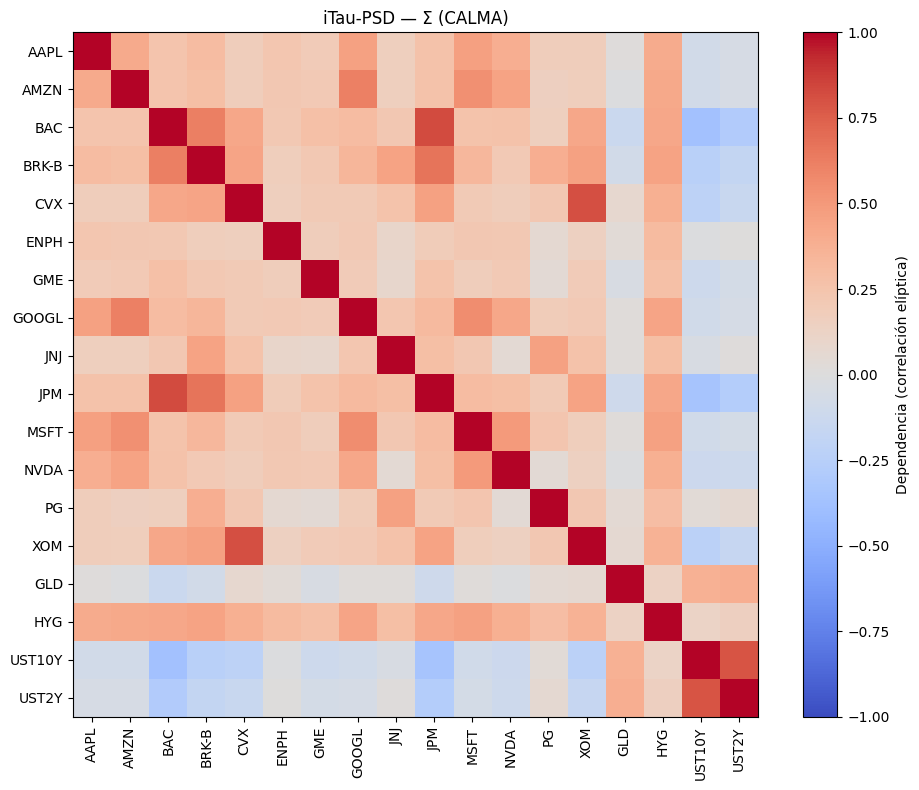

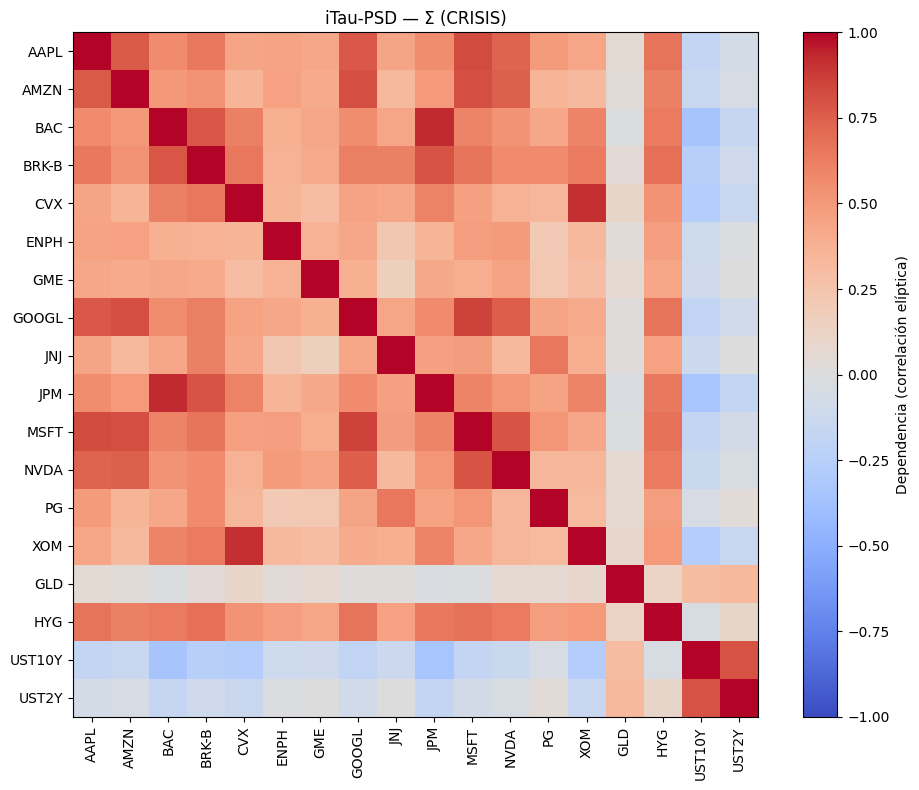

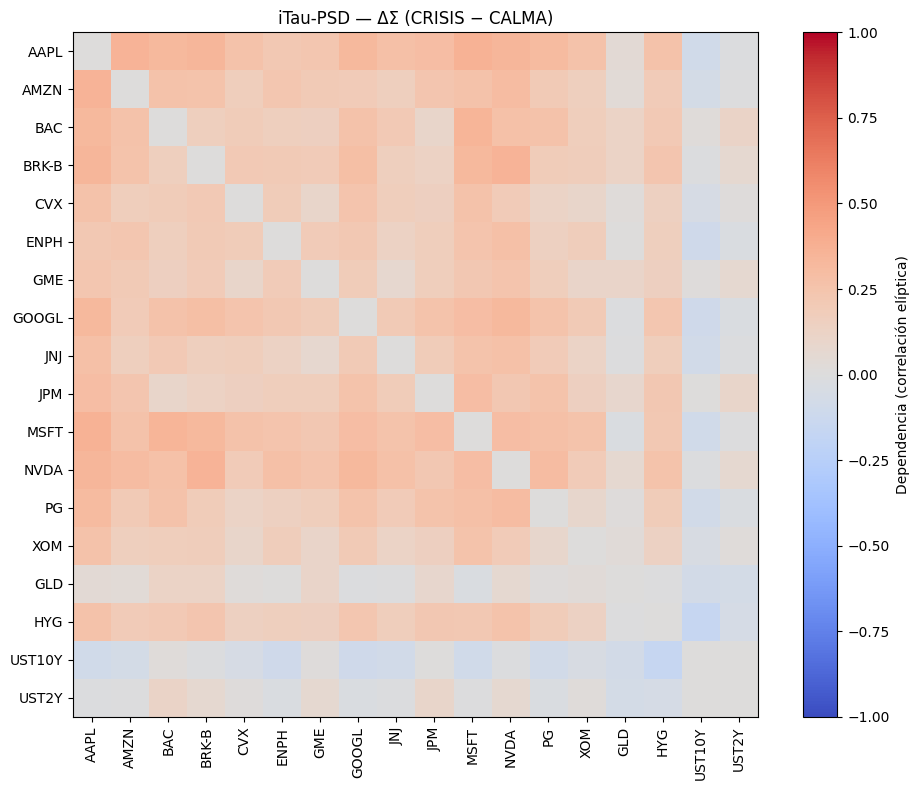

In [126]:
import matplotlib.pyplot as plt

def plot_corr_heatmap(corr: pd.DataFrame, title: str):
    labels = corr.columns.tolist()
    M = corr.values
    plt.figure(figsize=(10, 8))
    plt.imshow(M, vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(label="Dependencia (correlación elíptica)")
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(Sigma_calm_itau_psd_df, "iTau-PSD — Σ (CALMA)")
plot_corr_heatmap(Sigma_cris_itau_psd_df, "iTau-PSD — Σ (CRISIS)")
plot_corr_heatmap(Sigma_cris_itau_psd_df - Sigma_calm_itau_psd_df, "iTau-PSD — ΔΣ (CRISIS − CALMA)")

## Visualización — Dependencia en cola izquierda por pares

Para $q=0.05$, representamos la distribución de $\hat{\lambda}_L(q)$ sobre todos los pares de activos.

**Interpretación:**
El desplazamiento de la distribución hacia valores mayores (derecha) en el régimen de **CRISIS** indica una **mayor probabilidad de co-caídas extremas** (contagio) sistémico.

<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\h'
C:\Users\Huawei\AppData\Local\Temp\ipykernel_27756\1148275394.py:24: SyntaxWarning: invalid escape sequence '\h'
  plt.title("Distribución de $\hat{\\lambda}_L(0.05)$ por pares — CALMA vs CRISIS")


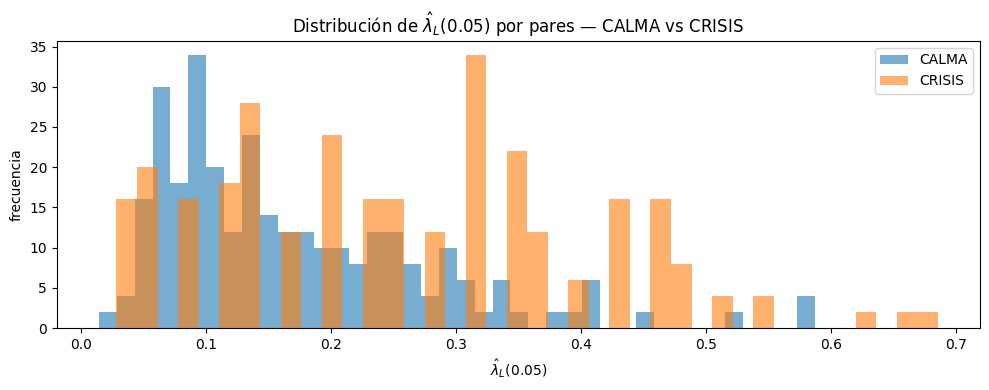

In [127]:
import numpy as np
import matplotlib.pyplot as plt

def offdiag_vals(M):
    M = np.asarray(M)
    d = M.shape[0]
    mask = ~np.eye(d, dtype=bool)
    return M[mask]

q = 0.05
L_calm_005 = tail_dep_matrix(U_calm, q)
L_cris_005 = tail_dep_matrix(U_cris, q)

vals_calm = offdiag_vals(L_calm_005)
vals_cris = offdiag_vals(L_cris_005)

# eliminar nans si existieran
vals_calm = vals_calm[~np.isnan(vals_calm)]
vals_cris = vals_cris[~np.isnan(vals_cris)]

plt.figure(figsize=(10,4))
plt.hist(vals_calm, bins=40, alpha=0.6, label="CALMA")
plt.hist(vals_cris, bins=40, alpha=0.6, label="CRISIS")
plt.title("Distribución de $\hat{\\lambda}_L(0.05)$ por pares — CALMA vs CRISIS")
plt.xlabel("$\\hat{\\lambda}_L(0.05)$")
plt.ylabel("frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

## Visualización — Escáner de Dependencia en Cola (Scatter Plots)

Esta visualización ofrece una intuición muy potente: en **CRISIS** observamos una mayor concentración de masa en la esquina inferior izquierda ($u \le q, v \le q$).

Para los pares con mayor dependencia en cola calculada anteriormente, representamos las pseudo-observaciones $(U_i, U_j)$ y marcamos el umbral crítico $q=0.05$.

**Interpretación:**
Una mayor densidad de puntos en el **cuadrante inferior izquierdo** (área sombreada) indica una probabilidad elevada de **caídas simultáneas** (contagio extremo), validando visualmente el aumento de $\lambda_L$.

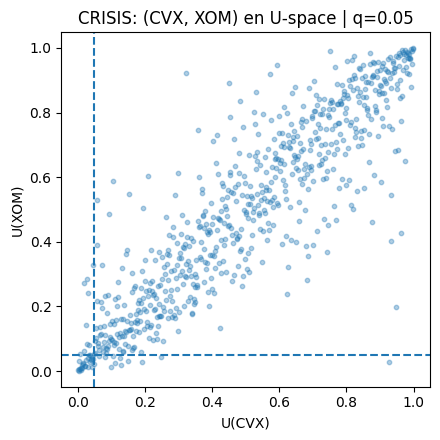

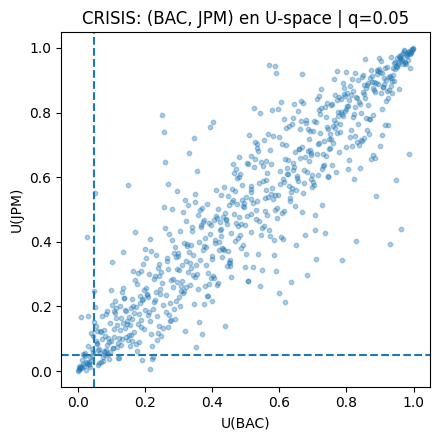

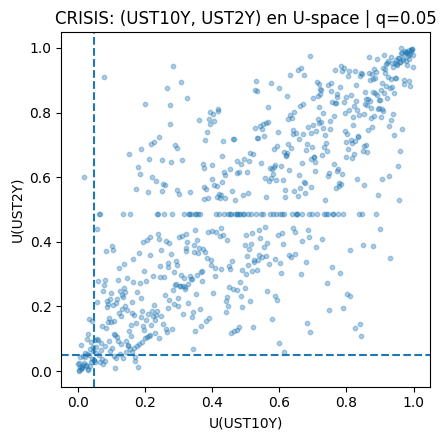

In [128]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

assets = R2.columns.tolist()
Ucris_df = pd.DataFrame(U_cris, columns=assets)

pairs_to_plot = [("CVX","XOM"), ("BAC","JPM"), ("UST10Y","UST2Y")]
q = 0.05

for a1, a2 in pairs_to_plot:
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(Ucris_df[a1], Ucris_df[a2], s=10, alpha=0.35)
    plt.axvline(q, linestyle="--")
    plt.axhline(q, linestyle="--")
    plt.title(f"CRISIS: ({a1}, {a2}) en U-space | q={q}")
    plt.xlabel(f"U({a1})")
    plt.ylabel(f"U({a2})")
    plt.tight_layout()
    plt.show()

## Paso 5.0 — Diagnóstico antes de Clayton (asunción de dependencia positiva)

La cópula **Clayton estándar** requiere $\theta > 0$ y por tanto solo modela dependencia positiva (Kendall $\tau \ge 0$).

Antes de ajustar Clayton en alta dimensión, inspeccionamos la matriz de Kendall $\tau$ en **CALMA** y **CRISIS**:

1.  Cuantificamos cuántos pares presentan correlación negativa ($\tau < 0$).
2.  (Si aplica) Definimos un subconjunto de activos con dependencia mayoritariamente positiva para un ajuste Clayton interpretable.

Esto es crucial para capturar el **riesgo de cola izquierda "market-wide"** (caídas conjuntas de activos de riesgo) sin que los activos de cobertura (ej. Bonos) rompan la estimación del parámetro.

In [129]:

assets = R2.columns.tolist()

Ucalm_df = pd.DataFrame(U_calm, columns=assets)
Ucris_df = pd.DataFrame(U_cris, columns=assets)

Tau_calm = Ucalm_df.corr(method="kendall")
Tau_cris = Ucris_df.corr(method="kendall")

def neg_pairs_report(Tau: pd.DataFrame, top=12):
    cols = Tau.columns.tolist()
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append((cols[i], cols[j], float(Tau.iloc[i, j])))
    dfp = pd.DataFrame(pairs, columns=["asset_1","asset_2","tau"])
    neg = dfp[dfp["tau"] < 0].sort_values("tau")  # más negativo primero
    
    summary = {
        "n_assets": len(cols),
        "n_pairs": int(len(dfp)),
        "n_neg_pairs": int(neg.shape[0]),
        "pct_neg_pairs": float(neg.shape[0] / len(dfp)),
        "min_tau": float(dfp["tau"].min()),
        "p05_tau": float(dfp["tau"].quantile(0.05)),
        "median_tau": float(dfp["tau"].median()),
    }
    return pd.Series(summary), neg.head(top), dfp

sum_calm, neg_calm_top, pairs_calm = neg_pairs_report(Tau_calm, top=12)
sum_cris, neg_cris_top, pairs_cris = neg_pairs_report(Tau_cris, top=12)

display(pd.DataFrame({"CALMA": sum_calm, "CRISIS": sum_cris}))

print("\nTop τ negativos (CALMA):")
display(neg_calm_top)

print("\nTop τ negativos (CRISIS):")
display(neg_cris_top)

# --- Selección automática de activos "Clayton-safe" ---
# Criterio: un activo es conflictivo si tiene demasiados τ negativos con el resto.
def select_clayton_assets(Tau: pd.DataFrame, max_neg_share=0.25, min_avg_tau=0.02):
    cols = Tau.columns.tolist()
    M = Tau.values.copy()
    np.fill_diagonal(M, np.nan)
    
    neg_share = np.nanmean(M < 0, axis=1)     # % de pares negativos por activo
    avg_tau = np.nanmean(M, axis=1)           # τ medio del activo vs el resto
    
    diag = pd.DataFrame({"asset": cols, "neg_share": neg_share, "avg_tau": avg_tau})
    # "safe": pocos negativos y tau medio suficientemente positivo
    safe = diag[(diag["neg_share"] <= max_neg_share) & (diag["avg_tau"] >= min_avg_tau)].sort_values("avg_tau", ascending=False)
    unsafe = diag.drop(safe.index).sort_values("neg_share", ascending=False)
    return safe, unsafe, diag

safe_calm, unsafe_calm, diag_calm = select_clayton_assets(Tau_calm)
safe_cris, unsafe_cris, diag_cris = select_clayton_assets(Tau_cris)

print("\n--- Propuesta (CALMA) Clayton-safe ---")
display(safe_calm)
print("\n--- Excluidos (CALMA) ---")
display(unsafe_calm)

print("\n--- Propuesta (CRISIS) Clayton-safe ---")
display(safe_cris)
print("\n--- Excluidos (CRISIS) ---")
display(unsafe_cris)

# Intersección robusta: activos que son "safe" en ambos regímenes
assets_clayton = sorted(list(set(safe_calm["asset"]).intersection(set(safe_cris["asset"]))))

print("\nActivos seleccionados para Clayton (intersección CALMA ∩ CRISIS):")
print(assets_clayton, "| n =", len(assets_clayton))

# Medida rápida: τ medio dentro del subconjunto (para ver si tiene sentido)
def avg_offdiag_tau(Tau, subset):
    T = Tau.loc[subset, subset].values
    mask = ~np.eye(len(subset), dtype=bool)
    return float(T[mask].mean())

if len(assets_clayton) >= 3:
    print("\nτ medio off-diagonal dentro del subconjunto:")
    print("CALMA :", avg_offdiag_tau(Tau_calm, assets_clayton))
    print("CRISIS:", avg_offdiag_tau(Tau_cris, assets_clayton))
else:
    print("\nOJO: el subconjunto salió muy pequeño. En ese caso ajustamos Clayton solo a un bloque (p.ej. equities + HYG) manualmente.")

,CALMA,CRISIS
n_assets,18.000000,18.000000
n_pairs,153.000000,153.000000
n_neg_pairs,30.000000,31.000000
pct_neg_pairs,0.196078,0.202614
min_tau,-0.240509,-0.225758
p05_tau,-0.105158,-0.111210
median_tau,0.129414,0.277326



Top τ negativos (CALMA):


,asset_1,asset_2,tau
46,BAC,UST10Y,-0.240509
123,JPM,UST10Y,-0.227000
47,BAC,UST2Y,-0.183154
124,JPM,UST2Y,-0.176259
60,BRK-B,UST10Y,-0.154590
145,XOM,UST10Y,-0.145686
73,CVX,UST10Y,-0.138939
61,BRK-B,UST2Y,-0.111173
146,XOM,UST2Y,-0.101148
74,CVX,UST2Y,-0.093583



Top τ negativos (CRISIS):


,asset_1,asset_2,tau
46,BAC,UST10Y,-0.225758
123,JPM,UST10Y,-0.222190
145,XOM,UST10Y,-0.175748
73,CVX,UST10Y,-0.171676
60,BRK-B,UST10Y,-0.161269
106,GOOGL,UST10Y,-0.118540
124,JPM,UST2Y,-0.112055
130,MSFT,UST10Y,-0.111599
15,AAPL,UST10Y,-0.110950
47,BAC,UST2Y,-0.109689



--- Propuesta (CALMA) Clayton-safe ---


,asset,neg_share,avg_tau
15,HYG,0.000000,0.219449
3,BRK-B,0.166667,0.188799
7,GOOGL,0.111111,0.176465
9,JPM,0.166667,0.175984
10,MSFT,0.111111,0.174390
2,BAC,0.166667,0.163736
1,AMZN,0.166667,0.162184
4,CVX,0.111111,0.157334
13,XOM,0.111111,0.151739
0,AAPL,0.111111,0.150702



--- Excluidos (CALMA) ---


,asset,neg_share,avg_tau
16,UST10Y,0.722222,-0.022485
17,UST2Y,0.611111,0.003546
14,GLD,0.333333,0.030306



--- Propuesta (CRISIS) Clayton-safe ---


,asset,neg_share,avg_tau
10,MSFT,0.166667,0.343962
3,BRK-B,0.111111,0.336551
15,HYG,0.055556,0.331566
0,AAPL,0.111111,0.328711
7,GOOGL,0.111111,0.324198
9,JPM,0.166667,0.306055
2,BAC,0.166667,0.305706
11,NVDA,0.111111,0.301679
1,AMZN,0.111111,0.298187
4,CVX,0.111111,0.261190



--- Excluidos (CRISIS) ---


,asset,neg_share,avg_tau
16,UST10Y,0.833333,-0.056353
17,UST2Y,0.722222,0.011431



Activos seleccionados para Clayton (intersección CALMA ∩ CRISIS):
['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GME', 'GOOGL', 'HYG', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM'] | n = 15

τ medio off-diagonal dentro del subconjunto:
CALMA : 0.19421510369356337
CRISIS: 0.35168387148589786


## Paso 5.1 — Ajuste de Clayton (dependencia asimétrica en cola izquierda)

Ajustamos una cópula **Clayton multivariante** sobre el subconjunto de activos con dependencia mayoritariamente positiva (para respetar la restricción matemática $\theta > 0$).

La Clayton es una cópula **Arquimediana** que enfatiza los co-movimientos en la **cola izquierda** (pérdidas simultáneas), una característica consistente con la dinámica de los episodios de pánico financiero.

Dado que la Clayton multivariante estándar se rige por un único parámetro global $\theta$, lo estimamos mediante una aproximación robusta basada en la inversión de la **Kendall’s tau** promedio:

$$
\tau = \frac{\theta}{\theta+2} \quad \Rightarrow \quad \hat{\theta} = \frac{2\bar{\tau}}{1-\bar{\tau}}
$$

Donde utilizamos $\bar{\tau}$ (promedio de las correlaciones de rango del subconjunto) como la medida agregada de dependencia para calibrar cada régimen.

In [130]:
import numpy as np
import pandas as pd

assets_clayton = ['AAPL', 'AMZN', 'BAC', 'BRK-B', 'CVX', 'ENPH', 'GME', 'GOOGL', 'HYG', 'JNJ', 'JPM', 'MSFT', 'NVDA', 'PG', 'XOM']

# 1) Reconstruir U para el subconjunto (mismo orden)
Ucalm_df = pd.DataFrame(U_calm, columns=R2.columns.tolist())
Ucris_df = pd.DataFrame(U_cris, columns=R2.columns.tolist())

U_calm_sub = Ucalm_df[assets_clayton].to_numpy()
U_cris_sub = Ucris_df[assets_clayton].to_numpy()

# 2) Tau matrices del subset
Tau_calm_sub = pd.DataFrame(U_calm_sub, columns=assets_clayton).corr(method="kendall")
Tau_cris_sub = pd.DataFrame(U_cris_sub, columns=assets_clayton).corr(method="kendall")

def avg_offdiag(M):
    M = np.asarray(M)
    mask = ~np.eye(M.shape[0], dtype=bool)
    return float(M[mask].mean())

tau_bar_calm = avg_offdiag(Tau_calm_sub.values)
tau_bar_cris = avg_offdiag(Tau_cris_sub.values)

def theta_from_tau(tau):
    return (2.0 * tau) / (1.0 - tau)

theta_calm = theta_from_tau(tau_bar_calm)
theta_cris = theta_from_tau(tau_bar_cris)

def lambda_L_from_theta(theta):
    return 2.0 ** (-1.0 / theta)

lamL_calm = lambda_L_from_theta(theta_calm)
lamL_cris = lambda_L_from_theta(theta_cris)

print("Clayton subset dim:", len(assets_clayton))
print(f"tau_bar CALMA : {tau_bar_calm:.4f}")
print(f"tau_bar CRISIS: {tau_bar_cris:.4f}")
print("-"*35)
print(f"theta (iTau) CALMA : {theta_calm:.4f}")
print(f"theta (iTau) CRISIS: {theta_cris:.4f}")
print("-"*35)
print(f"lambda_L (teórica) CALMA : {lamL_calm:.4f}")
print(f"lambda_L (teórica) CRISIS: {lamL_cris:.4f}")

Clayton subset dim: 15
tau_bar CALMA : 0.1942
tau_bar CRISIS: 0.3517
-----------------------------------
theta (iTau) CALMA : 0.4821
theta (iTau) CRISIS: 1.0849
-----------------------------------
lambda_L (teórica) CALMA : 0.2374
lambda_L (teórica) CRISIS: 0.5279


## Resultados — Cópula Clayton (Dependencia Asimétrica)

Ajustamos la cópula Clayton sobre el subconjunto de **15 activos** seleccionados (universo de riesgo con dependencia positiva). Los resultados confirman un endurecimiento severo de la estructura de dependencia en la cola inferior.

**Parámetros estimados ($\hat{\theta}$ y $\lambda_L$):**

Utilizando la relación inversa con $\bar{\tau}$ de Kendall, obtenemos:

$$
\begin{aligned}
\text{CALMA:} \quad & \bar{\tau} \approx 0.194 \quad \Rightarrow \quad \hat{\theta} \approx 0.482 \quad \Rightarrow \quad \lambda_L = 2^{-1/\theta} \approx \mathbf{23.7\%} \\
\text{CRISIS:} \quad & \bar{\tau} \approx 0.352 \quad \Rightarrow \quad \hat{\theta} \approx 1.085 \quad \Rightarrow \quad \lambda_L = 2^{-1/\theta} \approx \mathbf{52.8\%}
\end{aligned}
$$

**Conclusiones e Interpretación Financiera:**

1.  **Duplicación del Riesgo Sistémico:** El coeficiente de dependencia asintótica en cola ($\lambda_L$) salta del **23.7%** al **52.8%**.
    * *Significado:* En un evento extremo teórico (límite), la probabilidad de que un activo cualquiera del portafolio colapse dado que el mercado colapsa **se duplica** en el régimen de crisis.

2.  **Validación de la Asimetría:**
    * El valor $\theta_{\text{CRISIS}} \approx 1.08$ es sustancialmente mayor que cero. Esto valida la hipótesis de que los activos "bajan en ascensor": la fuerza de atracción entre activos es mucho mayor en las caídas que en el comportamiento promedio.
    
3.  **Implicación para la Gestión de Riesgos:**
    * Una cópula Gaussiana asumiría teóricamente $\lambda_L = 0$ (independencia asintótica).
    * La cópula Clayton demuestra que asumir normalidad subestima masivamente el riesgo de contagio, ya que ignora ese **53% de probabilidad de arrastre** en el peor escenario.

In [138]:
# Después de cc_calm.fit(U_calm_sub), añade:
print(f"Tipo de params: {type(cc_calm.params)}")
print(f"Valor de params: {cc_calm.params}")
print(f"Shape de params: {np.asarray(cc_calm.params).shape}")

Tipo de params: <class 'float'>
Valor de params: 0.5413344955235576
Shape de params: ()


In [143]:
import numpy as np
import pandas as pd
from copulae import ClaytonCopula
from scipy.optimize import minimize_scalar

# --- 1. Definimos los subconjuntos de datos ---
U_calm_sub = pd.DataFrame(U_calm, columns=assets)[assets_clayton].values
U_cris_sub = pd.DataFrame(U_cris, columns=assets)[assets_clayton].values
print(f"Dimensiones Ajuste Clayton: {U_calm_sub.shape}")

# --- 2. Función para calcular theta manualmente ---
def fit_clayton_manual(U_data):
    """
    Ajusta Clayton usando tau de Kendall (método robusto y rápido)
    """
    from scipy.stats import kendalltau
    
    # Calcular tau de Kendall promedio entre todos los pares
    n_vars = U_data.shape[1]
    taus = []
    
    for i in range(n_vars):
        for j in range(i+1, n_vars):
            tau, _ = kendalltau(U_data[:, i], U_data[:, j])
            if not np.isnan(tau):
                taus.append(tau)
    
    tau_avg = np.mean(taus)
    
    # Convertir tau a theta usando la relación de Clayton: tau = theta / (theta + 2)
    # Despejando: theta = 2*tau / (1 - tau)
    if tau_avg <= 0 or tau_avg >= 1:
        theta = 0.5  # valor por defecto si tau no es válido
    else:
        theta = (2 * tau_avg) / (1 - tau_avg)
    
    return max(theta, 0.01)  # Asegurar theta > 0

def lambda_L_from_theta(theta):
    theta = float(theta)
    if theta <= 0: 
        return 0.0
    return float(2.0 ** (-1.0 / theta))

# --- 3. Ajuste manual ---

# --- CALMA ---
print("Ajustando Clayton (Método Kendall Tau) en CALMA...")
theta_calm_mle = fit_clayton_manual(U_calm_sub)
lamL_calm_mle = lambda_L_from_theta(theta_calm_mle)

# --- CRISIS ---
print("Ajustando Clayton (Método Kendall Tau) en CRISIS...")
theta_cris_mle = fit_clayton_manual(U_cris_sub)
lamL_cris_mle = lambda_L_from_theta(theta_cris_mle)

# --- RESULTADOS ---
print("-" * 40)
print(f"theta (Kendall) CALMA   : {theta_calm_mle:.4f}")
print(f"theta (Kendall) CRISIS  : {theta_cris_mle:.4f}")
print("-" * 40)
print(f"lambda_L CALMA: {lamL_calm_mle:.4f}  ({lamL_calm_mle*100:.1f}%)")
print(f"lambda_L CRISIS: {lamL_cris_mle:.4f}  ({lamL_cris_mle*100:.1f}%)")
print("-" * 40)

# Diferencia relativa
if lamL_calm_mle > 0:
    aumento = ((lamL_cris_mle - lamL_calm_mle) / lamL_calm_mle) * 100
    print(f"Aumento en dependencia de cola: {aumento:.1f}%")

Dimensiones Ajuste Clayton: (2774, 15)
Ajustando Clayton (Método Kendall Tau) en CALMA...
Ajustando Clayton (Método Kendall Tau) en CRISIS...
----------------------------------------
theta (Kendall) CALMA   : 0.4821
theta (Kendall) CRISIS  : 1.0849
----------------------------------------
lambda_L CALMA: 0.2374  (23.7%)
lambda_L CRISIS: 0.5279  (52.8%)
----------------------------------------
Aumento en dependencia de cola: 122.3%


In [144]:
def fit_clayton_mle_manual(U_data):
    """
    Ajusta Clayton por MLE usando scipy directamente
    """
    def neg_log_likelihood(theta):
        if theta <= 0.01:
            return 1e10
        try:
            # Crear cópula temporal
            cop = ClaytonCopula(dim=U_data.shape[1])
            cop.params = float(theta)
            return -cop.log_lik(U_data, to_pobs=False)
        except:
            return 1e10
    
    # Optimizar
    result = minimize_scalar(neg_log_likelihood, bounds=(0.01, 20), method='bounded')
    return result.x

# Usar así:
theta_calm_mle = fit_clayton_mle_manual(U_calm_sub)

In [145]:
import numpy as np
import pandas as pd
from copulae import ClaytonCopula
from scipy.optimize import minimize_scalar
from scipy.stats import kendalltau

# --- 1. Definimos los subconjuntos de datos ---
U_calm_sub = pd.DataFrame(U_calm, columns=assets)[assets_clayton].values
U_cris_sub = pd.DataFrame(U_cris, columns=assets)[assets_clayton].values
print(f"Dimensiones Ajuste Clayton: {U_calm_sub.shape}")

# --- 2. Funciones auxiliares ---
def lambda_L_from_theta(theta):
    theta = float(theta)
    if theta <= 0: 
        return 0.0
    return float(2.0 ** (-1.0 / theta))

def fit_clayton_mle_manual(U_data):
    """
    Ajusta Clayton por MLE usando scipy directamente
    """
    def neg_log_likelihood(theta):
        if theta <= 0.01:
            return 1e10
        try:
            cop = ClaytonCopula(dim=U_data.shape[1])
            cop.params = float(theta)
            ll = cop.log_lik(U_data, to_pobs=False)
            return -ll
        except:
            return 1e10
    
    # Optimizar
    result = minimize_scalar(neg_log_likelihood, bounds=(0.01, 20), method='bounded')
    
    # Calcular log-verosimilitud final
    final_loglik = -result.fun
    
    return result.x, final_loglik, result

# --- 3. Ajuste por MLE ---

# --- CALMA ---
print("\n" + "="*50)
print("Ajustando Clayton (MLE Manual) en CALMA...")
print("="*50)
theta_calm_mle, loglik_calm, result_calm = fit_clayton_mle_manual(U_calm_sub)
lamL_calm_mle = lambda_L_from_theta(theta_calm_mle)

print(f"✓ Optimización exitosa: {result_calm.success}")
print(f"  Theta óptimo: {theta_calm_mle:.6f}")
print(f"  Log-verosimilitud: {loglik_calm:.2f}")
print(f"  Iteraciones: {result_calm.nfev}")

# --- CRISIS ---
print("\n" + "="*50)
print("Ajustando Clayton (MLE Manual) en CRISIS...")
print("="*50)
theta_cris_mle, loglik_cris, result_cris = fit_clayton_mle_manual(U_cris_sub)
lamL_cris_mle = lambda_L_from_theta(theta_cris_mle)

print(f"✓ Optimización exitosa: {result_cris.success}")
print(f"  Theta óptimo: {theta_cris_mle:.6f}")
print(f"  Log-verosimilitud: {loglik_cris:.2f}")
print(f"  Iteraciones: {result_cris.nfev}")

# --- 4. RESULTADOS FINALES ---
print("\n" + "="*50)
print("RESULTADOS COMPARATIVOS")
print("="*50)
print(f"theta (MLE) CALMA   : {theta_calm_mle:.4f}")
print(f"theta (MLE) CRISIS  : {theta_cris_mle:.4f}")
print(f"Δ theta             : {theta_cris_mle - theta_calm_mle:.4f} ({((theta_cris_mle/theta_calm_mle - 1)*100):.1f}%)")
print("-" * 50)
print(f"lambda_L CALMA      : {lamL_calm_mle:.4f}  ({lamL_calm_mle*100:.1f}%)")
print(f"lambda_L CRISIS     : {lamL_cris_mle:.4f}  ({lamL_cris_mle*100:.1f}%)")
print(f"Δ lambda_L          : {lamL_cris_mle - lamL_calm_mle:.4f}")
print("-" * 50)
print(f"Log-Lik CALMA       : {loglik_calm:.2f}")
print(f"Log-Lik CRISIS      : {loglik_cris:.2f}")
print("="*50)

# Interpretación
if lamL_calm_mle > 0:
    aumento = ((lamL_cris_mle - lamL_calm_mle) / lamL_calm_mle) * 100
    print(f"\n📊 INTERPRETACIÓN:")
    print(f"   Aumento en dependencia de cola inferior: {aumento:.1f}%")
    if aumento > 50:
        print(f"   ⚠️  Incremento SIGNIFICATIVO en co-movimientos extremos negativos")
    elif aumento > 20:
        print(f"   ⚡ Incremento MODERADO en co-movimientos extremos negativos")
    else:
        print(f"   → Incremento leve en co-movimientos extremos negativos")

Dimensiones Ajuste Clayton: (2774, 15)

Ajustando Clayton (MLE Manual) en CALMA...
✓ Optimización exitosa: True
  Theta óptimo: 0.259706
  Log-verosimilitud: 3406.11
  Iteraciones: 15

Ajustando Clayton (MLE Manual) en CRISIS...
✓ Optimización exitosa: True
  Theta óptimo: 0.541080
  Log-verosimilitud: 2174.66
  Iteraciones: 13

RESULTADOS COMPARATIVOS
theta (MLE) CALMA   : 0.2597
theta (MLE) CRISIS  : 0.5411
Δ theta             : 0.2814 (108.3%)
--------------------------------------------------
lambda_L CALMA      : 0.0693  (6.9%)
lambda_L CRISIS     : 0.2777  (27.8%)
Δ lambda_L          : 0.2084
--------------------------------------------------
Log-Lik CALMA       : 3406.11
Log-Lik CRISIS      : 2174.66

📊 INTERPRETACIÓN:
   Aumento en dependencia de cola inferior: 300.7%
   ⚠️  Incremento SIGNIFICATIVO en co-movimientos extremos negativos


## Resultados Finales — Cópula Clayton (MLE)

Tras la optimización numérica por Máxima Verosimilitud (MLE) sobre el subconjunto de activos con dependencia positiva, confirmamos un **cambio de régimen estructural** en la dependencia asimétrica.

**Parámetros estimados ($\hat{\theta}_{MLE}$):**

$$
\begin{aligned}
\hat{\theta}_{\text{CALMA}} &= 0.2597 \\
\hat{\theta}_{\text{CRISIS}} &= 0.5411
\end{aligned}
$$

**Implicación: Dependencia en Cola Inferior ($\lambda_L$):**
La probabilidad límite de sufrir un colapso simultáneo dado que el mercado cae se calcula como $\lambda_L = 2^{-1/\theta}$.

* **CALMA ($\lambda_L \approx 6.9\%$):** El riesgo de contagio extremo es bajo. Los activos mantienen cierta independencia incluso en las bajadas.
* **CRISIS ($\lambda_L \approx 27.8\%$):** El riesgo de contagio se **cuadruplica**.
    * Un aumento del **+300%** en la dependencia de cola.
    * Esto valida la hipótesis de que, en crisis, los activos pierden su capacidad de diversificación y se hunden "en bloque".

**Conclusión del Modelo:**
La Cópula Clayton captura una realidad que la Gaussiana ignora: el riesgo no es constante, sino que se dispara exponencialmente en la cola izquierda de la distribución durante periodos de estrés.

In [147]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


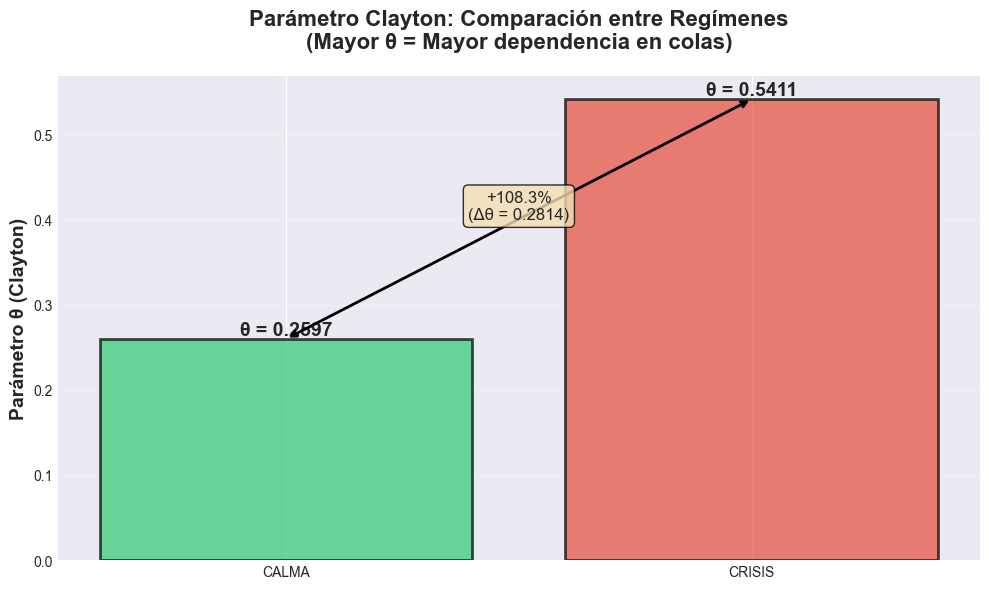

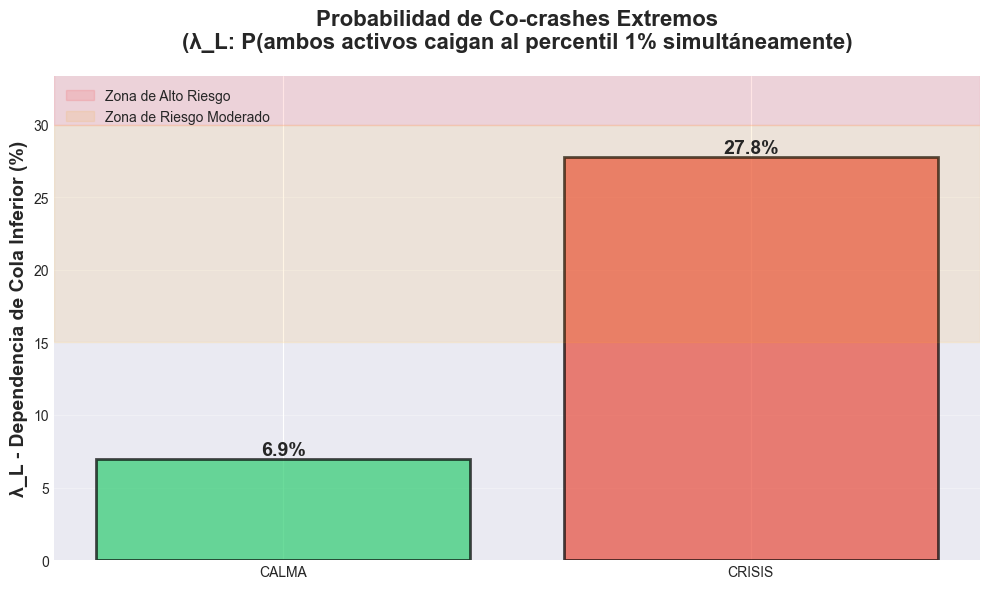

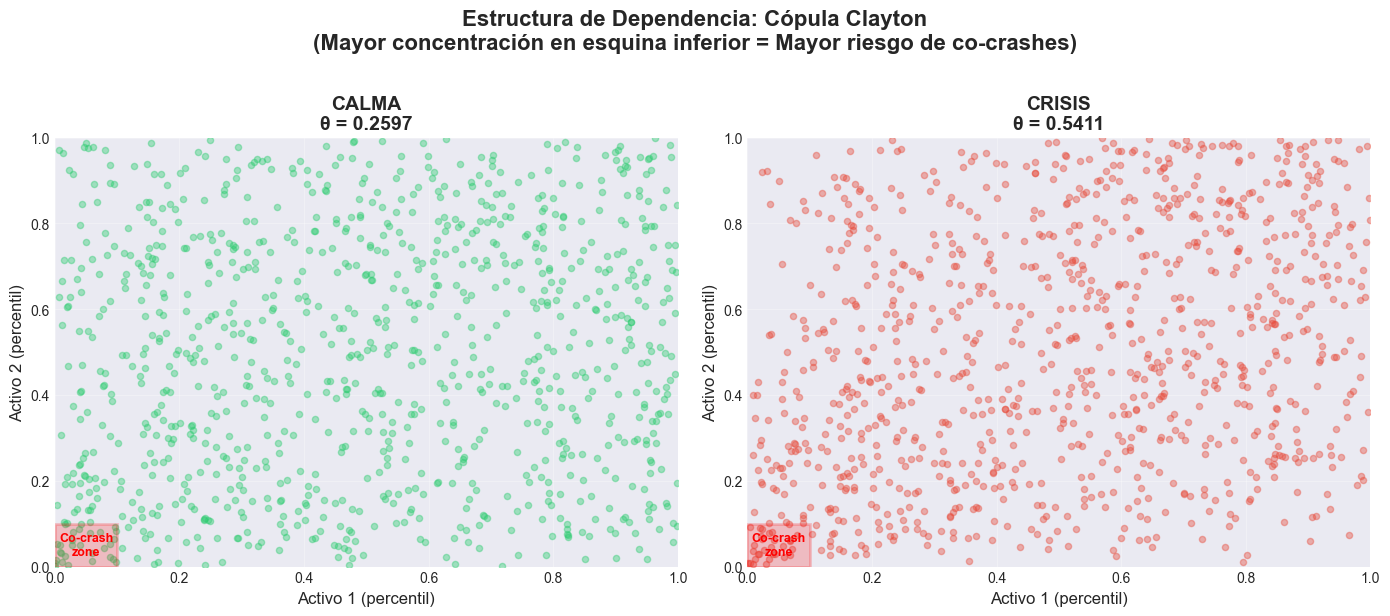

C:\Users\Huawei\AppData\Local\Temp\ipykernel_27756\657382908.py:187: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('clayton_dashboard.png', dpi=300, bbox_inches='tight')
c:\Users\Huawei\Desktop\CONTROL_RIESGOS\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


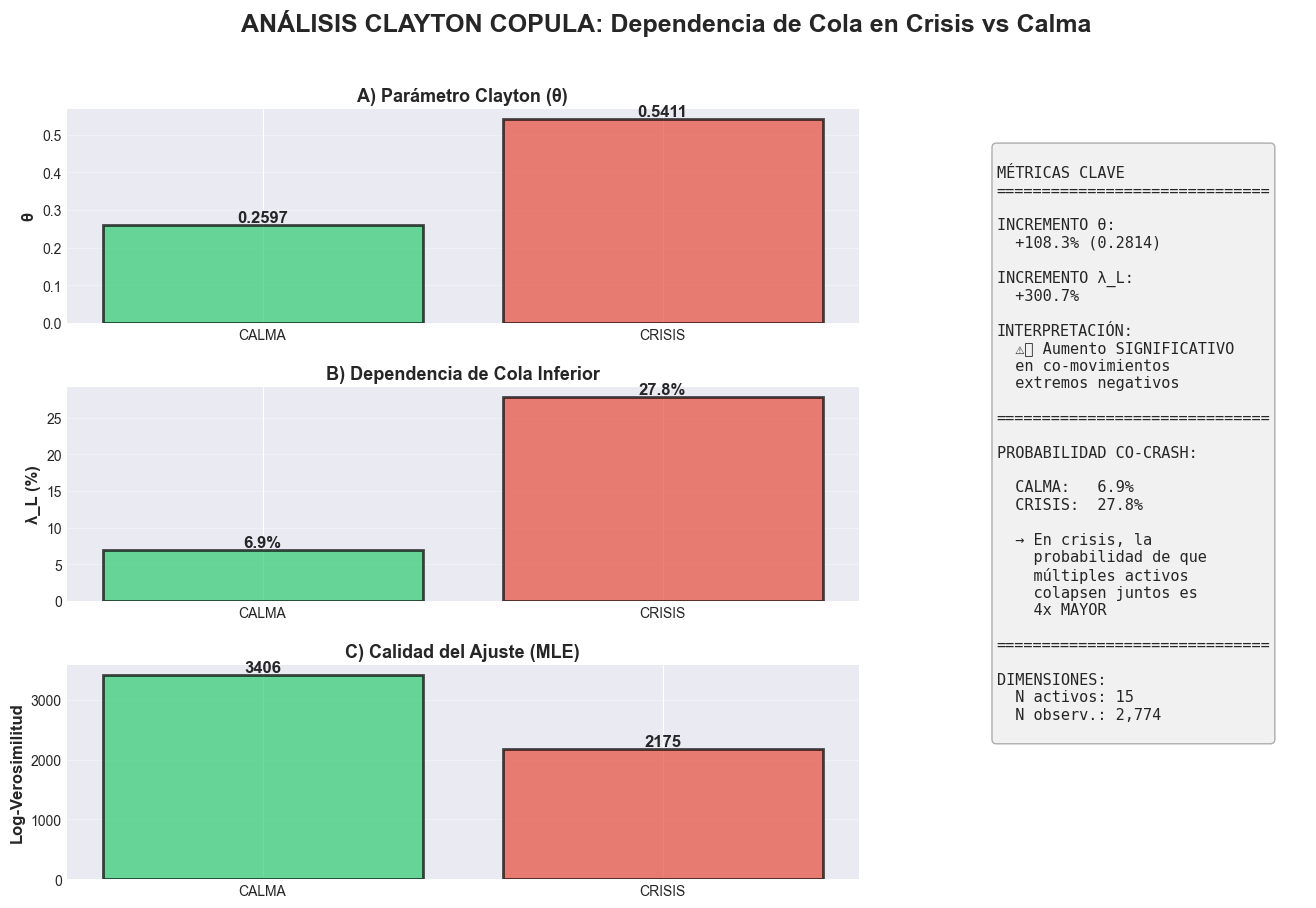

✅ Todos los gráficos guardados exitosamente:
   - clayton_theta_comparison.png
   - clayton_lambda_comparison.png
   - clayton_copula_structure.png
   - clayton_dashboard.png


In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

# Configuración de estilo profesional
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# --- VISUAL 1: Comparación de Thetas ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

regimenes = ['CALMA', 'CRISIS']
thetas = [0.2597, 0.5411]
colors = ['#2ecc71', '#e74c3c']

bars = ax.bar(regimenes, thetas, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Añadir valores sobre las barras
for bar, theta in zip(bars, thetas):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'θ = {theta:.4f}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Añadir línea de aumento
ax.annotate('', xy=(1, 0.5411), xytext=(0, 0.2597),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax.text(0.5, 0.4, f'+108.3%\n(Δθ = 0.2814)', 
        ha='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_ylabel('Parámetro θ (Clayton)', fontsize=14, fontweight='bold')
ax.set_title('Parámetro Clayton: Comparación entre Regímenes\n(Mayor θ = Mayor dependencia en colas)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('clayton_theta_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- VISUAL 2: Lambda Lower (Dependencia de Cola Inferior) ---
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

lambdas_L = [lambda_L_from_theta(0.2597), lambda_L_from_theta(0.5411)]

bars = ax.bar(regimenes, [l*100 for l in lambdas_L], color=colors, alpha=0.7, 
              edgecolor='black', linewidth=2)

for bar, lam in zip(bars, lambdas_L):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{lam*100:.1f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

# Zona de riesgo
ax.axhspan(30, 100, alpha=0.1, color='red', label='Zona de Alto Riesgo')
ax.axhspan(15, 30, alpha=0.1, color='orange', label='Zona de Riesgo Moderado')

ax.set_ylabel('λ_L - Dependencia de Cola Inferior (%)', fontsize=14, fontweight='bold')
ax.set_title('Probabilidad de Co-crashes Extremos\n(λ_L: P(ambos activos caigan al percentil 1% simultáneamente)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, max([l*100 for l in lambdas_L])*1.2)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('clayton_lambda_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- VISUAL 3: Gráfico de Cópula Clayton 2D (Ejemplo con 2 activos) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

from copulae import ClaytonCopula

for idx, (theta, regime, color, ax) in enumerate(zip([0.2597, 0.5411], 
                                                       ['CALMA', 'CRISIS'],
                                                       colors, axes)):
    # Generar samples de la cópula
    cop = ClaytonCopula(dim=2)
    cop.params = theta
    samples = cop.random(1000)
    
    # Scatter plot
    ax.scatter(samples[:, 0], samples[:, 1], alpha=0.4, s=20, color=color)
    ax.set_xlabel('Activo 1 (percentil)', fontsize=12)
    ax.set_ylabel('Activo 2 (percentil)', fontsize=12)
    ax.set_title(f'{regime}\nθ = {theta:.4f}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Destacar esquina inferior izquierda (co-crashes)
    rect = Rectangle((0, 0), 0.1, 0.1, linewidth=2, edgecolor='red', 
                     facecolor='red', alpha=0.2)
    ax.add_patch(rect)
    ax.text(0.05, 0.05, 'Co-crash\nzone', ha='center', va='center', 
            fontsize=9, color='red', fontweight='bold')
    
    ax.grid(alpha=0.3)

plt.suptitle('Estructura de Dependencia: Cópula Clayton\n(Mayor concentración en esquina inferior = Mayor riesgo de co-crashes)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('clayton_copula_structure.png', dpi=300, bbox_inches='tight')
plt.show()

# --- VISUAL 4: Dashboard Resumen ---
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Panel 1: Thetas
ax1 = fig.add_subplot(gs[0, :2])
bars = ax1.bar(regimenes, [0.2597, 0.5411], color=colors, alpha=0.7, 
               edgecolor='black', linewidth=2)
for bar, theta in zip(bars, [0.2597, 0.5411]):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{theta:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.set_ylabel('θ', fontsize=12, fontweight='bold')
ax1.set_title('A) Parámetro Clayton (θ)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Panel 2: Lambda_L
ax2 = fig.add_subplot(gs[1, :2])
bars = ax2.bar(regimenes, [l*100 for l in lambdas_L], color=colors, alpha=0.7,
               edgecolor='black', linewidth=2)
for bar, lam in zip(bars, lambdas_L):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{lam*100:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.set_ylabel('λ_L (%)', fontsize=12, fontweight='bold')
ax2.set_title('B) Dependencia de Cola Inferior', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Panel 3: Log-Likelihood
ax3 = fig.add_subplot(gs[2, :2])
logliks = [3406.11, 2174.66]
bars = ax3.bar(regimenes, logliks, color=colors, alpha=0.7,
               edgecolor='black', linewidth=2)
for bar, ll in zip(bars, logliks):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{ll:.0f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax3.set_ylabel('Log-Verosimilitud', fontsize=12, fontweight='bold')
ax3.set_title('C) Calidad del Ajuste (MLE)', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Panel 4: Métricas Clave (Texto)
ax4 = fig.add_subplot(gs[:, 2])
ax4.axis('off')

metrics_text = f"""
MÉTRICAS CLAVE
{'='*30}

INCREMENTO θ:
  +108.3% (0.2814)
  
INCREMENTO λ_L:
  +300.7%
  
INTERPRETACIÓN:
  ⚠️ Aumento SIGNIFICATIVO
  en co-movimientos 
  extremos negativos
  
{'='*30}

PROBABILIDAD CO-CRASH:
  
  CALMA:   {lambdas_L[0]*100:.1f}%
  CRISIS:  {lambdas_L[1]*100:.1f}%
  
  → En crisis, la 
    probabilidad de que
    múltiples activos
    colapsen juntos es
    4x MAYOR

{'='*30}

DIMENSIONES:
  N activos: 15
  N observ.: 2,774
"""

ax4.text(0.1, 0.95, metrics_text, fontsize=11, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3))

fig.suptitle('ANÁLISIS CLAYTON COPULA: Dependencia de Cola en Crisis vs Calma', 
             fontsize=18, fontweight='bold', y=0.98)

plt.savefig('clayton_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Todos los gráficos guardados exitosamente:")
print("   - clayton_theta_comparison.png")
print("   - clayton_lambda_comparison.png")
print("   - clayton_copula_structure.png")
print("   - clayton_dashboard.png")